# The little dataset that could

### Once upon a time there was a trade, it wasn't the biggest trade, it wasn't the smallest trade, but it was a trade. And thats what counted. - Financial advice from The Derek Zoolander Center for children who can't read good and wanna do other stuff good too.

# Analysis on trading data


## Description of the Data:

3 CSV files. 
1 containing all the trades Ryan made in the last 1.5 years. And various data associated with the stock and trade.
2 containing stock specific data, market cap, sector etc.

## Data Analysis goals:

Ultimate goal is a method to compute the stock variance for the current day or in real time if possible. Use this to suggest a stop loss that will not be triggered by noise. When a news event occurs, Ryan will predict a price direction and what a likely gain amount could be. But he needs to understand where to place his stop to take advantage of the move. 

The hypothethis is that if you can place a stop and have a high confidance interval to be outside of the noise, if the stop gets triggered, its an indicator that the move prediction was wrong. Otherwise you are well placed to take advantage of the new direction.

Another goal is to use XGBoost to predict losses for all the winning trades, and wins for all the losing trades. In order to guess at where Ryan would have put his stop for wins, or potential gains from losses. Unclear how accurate this would be.

Additional goals are:
+ Find metric and/or correlations to predict noise of a stock
+ Find a formula to predict the likelyhood of getting stopped out based on certain metrics from a given stock
+ Find correlations that cause Ryan to make a winning trade
+ Display general trading stats.

Split dataset:
+ long/short
+ win/loss
+ Useful trades (Specific slice of the dataset taking out sectors he no longer trades)
+ Swing trades (Swing trading is trader jargon for a longer term trade)

Other possible metrics:
The velocity of the stock (how often it changes hands). This would be something like float - institutional ownership / volume.
How much 1 share sold/bought effects the price.

**Stock data:**
*This is outside the scope of this notebook.*

* data of all ticks, quotes, offers, for all stocks over the last 4 years.
* Condense into 1 second candles.
* Sample tick data over 1 year.
* Uncompress any data over 1 year.

Extract all moves over 10% (for example) within 2 weeks. Sample slices with minimum gain of 5%, get difference between point and min over remaining period. This shows the highest minimum price point to put a stop that would not be triggered by that move. Do this for up and down trends. After training, return confidance interval of being outside random noise factor.

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm
%matplotlib inline
import json
import datetime
from dateutil import parser
from scipy.stats import linregress, norm
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV,StratifiedKFold
from xgboost import XGBClassifier,XGBRegressor, plot_importance
import xgboost as xgb
import os
import operator
import random
import copy
# For XGBoost
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [122]:
# Helper functions

def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull())
            if i>=j:
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else:
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)
def hist_it1(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def correlation_matrix(df,labels):
    fig = plt.figure()
    axes_length = len(labels)
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Trading Correlations')
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    plt.show()
    
#     cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def background_gradient(s, m=None, M=None, cmap='PuBu', low=0, high=0):
    print(s.shape)
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(norm)

    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret
    
def magnify():
    return [dict(selector="th",props=[("font-size", "7pt")]),
            dict(selector="td",props=[('padding', "0em 0em")]),
            dict(selector="th:hover",props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

def return_uniques(values):
    unqiue, count = np.unique(values, return_counts=True)
    print(unqiue, count)
    return unqiue, count

def display_data(values):
#     unique, counts = np.unique(values, return_counts=True)
#     print('unique, counts',unique, counts)
    for i in range(values.shape[0]):
        print(values[i])

def display_data_types(values):
    types = [type(value) for value in values]
    unqiue_types = set(types)
    print(unqiue_types)

In [123]:
# Load the data
# All ryan's trades
old_trades = pd.read_csv('/Users/morgan/Downloads/Trades - 2_21.csv')
trades = pd.read_csv('/Users/morgan/Downloads/cryt_use.csv')
# next two are stock attribute data sheets
# Finviz
finviz = pd.read_csv('/Users/morgan/Downloads/finviz data - data.csv')
# Finbox - fairly well suited for data processing. Has NM and NA for nan values
finbox = pd.read_csv('/Users/morgan/Downloads/FNBX Data - data.csv')

print('Old Trades',old_trades.shape)
print('Trades',trades.shape)
print('Finviz',finviz.shape)
print('Finbox',finbox.shape)
trades.head(5)

Old Trades (2566, 217)
Trades (3062, 217)
Finviz (7592, 51)
Finbox (4150, 70)


,date,idsym,opendt,trader,symbol,quantity,is_long,closedt,realized,open_fill_id,...,volspike,postvolspike,atrbin,lo_atr,is_etf,vol_amp,ultra,lev,is_lev,use?
0,2017-11-30,22072,2017-11-30T14:52:51.000Z,CRYT,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
1,2017-11-30,22072,2017-11-30T14:39:23.000Z,CRYT,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
2,2017-11-30,22072,2017-11-30T14:44:13.000Z,CRYT,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
3,2017-11-30,22072,2017-11-30T15:39:58.000Z,CRYT,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
4,2017-11-30,2475,2017-11-30T14:19:07.000Z,CRYT,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,...,1.0,0.0,"(0.0175,0.884]",1.0,0,0.0,0,0,0,1.0


In [124]:
#Clean finviz data
finviz = finviz.replace({'%': ''},regex=True)
finviz = finviz.replace({',':''},regex=True)

In [125]:
finviz_categorical_columns = ['Sector', 'Industry', 'Country','Sector.1', 'Industry.1']
finviz_numerical_columns = ['Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash',
       'P/Free Cash Flow', 'Dividend Yield', 'EPS growth next year','EPS growth past 5 years', 'EPS growth next 5 years',
       'Sales growth past 5 years', 'EPS growth quarter over quarter',
       'Sales growth quarter over quarter', 'Shares Outstanding',
       'Shares Float', 'Institutional Ownership', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'LT Debt/Equity', 'Total Debt/Equity', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Beta', 'Average True Range',
       'Volatility (Month)', '52-Week High', '52-Week Low', 'Average Volume',
       'Relative Volume', 'Price', 'Change', 'Volume']

In [126]:
#Identify which numerical columns have the wrong datatypes.
finviz[finviz_numerical_columns]=finviz[finviz_numerical_columns].apply(pd.to_numeric)
# check the datatypes of the columns. make sure they are consistent.
for column in finviz_categorical_columns:
    print(column)
    display_data_types(finviz[column].values)
for column in finviz_numerical_columns:
    print(column)
    display_data_types(finviz[column].values)

Sector
{<class 'str'>}
Industry
{<class 'str'>}
Country
{<class 'str'>}
Sector.1
{<class 'numpy.float64'>}
Industry.1
{<class 'numpy.float64'>}
Market Cap
{<class 'numpy.float64'>}
P/E
{<class 'numpy.float64'>}
Forward P/E
{<class 'numpy.float64'>}
PEG
{<class 'numpy.float64'>}
P/S
{<class 'numpy.float64'>}
P/B
{<class 'numpy.float64'>}
P/Cash
{<class 'numpy.float64'>}
P/Free Cash Flow
{<class 'numpy.float64'>}
Dividend Yield
{<class 'numpy.float64'>}
EPS growth next year
{<class 'numpy.float64'>}
EPS growth past 5 years
{<class 'numpy.float64'>}
EPS growth next 5 years
{<class 'numpy.float64'>}
Sales growth past 5 years
{<class 'numpy.float64'>}
EPS growth quarter over quarter
{<class 'numpy.float64'>}
Sales growth quarter over quarter
{<class 'numpy.float64'>}
Shares Outstanding
{<class 'numpy.float64'>}
Shares Float
{<class 'numpy.float64'>}
Institutional Ownership
{<class 'numpy.float64'>}
Float Short
{<class 'numpy.float64'>}
Short Ratio
{<class 'numpy.float64'>}
Return on Assets


# Combining Finviz with Finbox for outside use

In [127]:
# Concat the two helper datasets and export to CSV
# Adding finbox to finviz
def combine_and_export():
    finbox_dict = {}
    used_dict = {}
    for index in range(finbox.shape[0]):
        finbox_dict[finbox['Ticker'][index]] = index
    finviz_rows = []
    count = 0
    for index, row in finviz.iterrows():
        try:
            ticker = row[1]
            if ticker in finbox_dict:
                used_dict[ticker] = count
                finviz_rows.append(row[3:])
                count += 1
        except:
            pass
    extra = pd.DataFrame(finviz_rows,index=range(len(finviz_rows)))
    used_finbox = []
    for index, row in finbox.iterrows():
        try:
            ticker = row[1]
            if ticker in used_dict:
                used_finbox.append(row)
        except:
            pass
    used_finbox = pd.DataFrame(used_finbox)
    combined_dataset = pd.concat([used_finbox,extra],axis=1)
    print(len(finbox.values))
    print(extra.shape)
    print(used_finbox.shape)
    print(combined_dataset.shape)
    print(used_finbox.head(5))
    extra.head(5)
    combined_dataset.to_csv('/Users/morgan/Downloads/FNBX_FINVIZ.csv')
# combine_and_export()

# Finviz Specific

Populate dictionary for indexing all of the stocks based on symbol

In [128]:
# Util for returning finviz stock data on request
finviz_dict = {}
for index in range(finviz.shape[0]):
    finviz_dict[finviz.Ticker[index]] = index
# Can pass a stock ticker and get the Finviz attributes returned
def get_stock_index(name):
    return finviz_dict[name]
use_finviz_dict = {}
for index in range(finviz.shape[0]):
#     print(int(finviz['use?'][index]))
    if int(finviz['use?'][index]) == 1:
        use_finviz_dict[finviz.Ticker[index]] = index
def get_used_stock_index(name):
    try:
        stock = use_finviz_dict[name]
        return stock
    except:
        return -1

# Add Finviz feature

Add feature by grabbing the finviz volatility column by stock symbol. 1/3rd of these are missing

In [129]:
# Add win/loss binary outcome column?
finviz_vols = []
# win_loss = []
for row in range(trades.shape[0]):
    #For volatility
    symbol = trades['symbol'][row]
    stock_index = get_used_stock_index(symbol)
#     print(stock_index)
    if stock_index != -1:
        stock_vol = finviz['Volatility (Month)'][stock_index]
        finviz_vols.append(stock_vol)
    else:
        finviz_vols.append(np.nan)
    #For win loss
#     amount = trades['realized'][row]
#     if amount > 0:
#         win_loss.append(1)
#     else:
#         win_loss.append(0)
# print(finviz_vols)
print('Number of NaN in column',finviz_vols.count(np.nan))
print('Total number of instances',len(finviz_vols))
trades['finviz_vol'] = finviz_vols
# trades['win/loss'] = win_loss

Number of NaN in column 1178
Total number of instances 3062


# Data cleaning

Add features, make the datatypes consistent, deal with missing and NaN values.

In [130]:
#fill use column missing values
trades = trades.drop(trades[['date','trader']],axis=1)
# Add feature per share return
trades['per_share_return'] = trades['realized'] / trades['quantity']
# Add Atr14/atr14_lag as percent
trades['atr14_percent'] = trades['atr14'] / trades['low']
trades['atr14_lag_percent'] = trades['atr14_lag'] / trades['low']
#make percent gain feature
gain_percs = []
for idx in range(trades.shape[0]):
    temp_gain = (pd.to_numeric(trades['average_exit_price'][idx]) - pd.to_numeric(trades['average_entry_price'][idx])) / pd.to_numeric(trades['average_entry_price'][idx])
    if pd.to_numeric(trades.is_long[idx]) == 0:
        temp_gain = 0-temp_gain   
    gain_percs.append(temp_gain)
trades['percent_gain'] = gain_percs
#make trade duration feature
trade_times = []
for idx in range(trades.shape[0]):
    trade_open = parser.parse(trades.opendt[idx])
    trade_close = parser.parse(trades.closedt[idx])
    trade_time = trade_close - trade_open
    trade_times.append(trade_time)
durations = [h.total_seconds() for h in trade_times]
trades['trade_duration'] = durations
#add overnight feature
overnight = []
for idx in range(trades.shape[0]):
    first_day = parser.parse(trades.opendt[idx]).day
    second_day = parser.parse(trades.closedt[idx]).day
    if second_day - first_day != 0:
        overnight.append(1)
    else:
        overnight.append(0)
trades['held_overnight'] = overnight
# Make sure no infs or -infs
trades.replace([np.inf, -np.inf], np.nan)
trades.replace(['inf', '-inf'], np.nan)
# caste these categorical columns into strings to avoid float NaNs
trades['entVenue'] = trades['entVenue'].astype(str)
trades['entLiqFlag'] = trades['entLiqFlag'].astype(str)
trades['entContra'] = trades['entContra'].astype(str)
trades['entAddTake'] = trades['entAddTake'].astype(str)
trades['exVenue'] = trades['exVenue'].astype(str)
trades['exLiqFlag'] = trades['exLiqFlag'].astype(str)
trades['exContra'] = trades['exContra'].astype(str)
trades['exAddTake'] = trades['exAddTake'].astype(str)
trades['newHiLo'] = trades['newHiLo'].astype(str)
trades['trend_long'] = trades['trend_long'].astype(str)
inf_mask = np.where(trades[['ay_ratio']].values == np.inf)[0]
# print(inf_mask)
trades.loc[trades['ay_ratio'] == np.inf,['ay_ratio']] = np.nan
# inf_ex = trades_num['ay_ratio'][inf_mask].values[0]
# print(np.isinf(inf_ex))
# print(trades_num['ay_ratio'][inf_mask])
# max(trades_num[['acv_atr']].values)
trades.head(5)

,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,lev,is_lev,use?,finviz_vol,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,1.0,2.26,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,1.0,2.26,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,1.0,2.26,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,1.0,2.26,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,1.0,1.75,0.000280,0.032441,0.024061,0.000010,3381138.0,1


# Remove columns that add no information
Delete columns with only 1 unique value

In [131]:
# Show columns with low number of unique values. Unique values @1 can be deleted as they contain no information
trades.isnull().sum(axis=1).head(15)
trades.isnull().sum(axis=0).head(15)
feats_counts = trades.nunique(dropna = False)
print(feats_counts.sort_values()[:10])
feats_counts = feats_counts.sort_values()
redundant_feats = feats_counts.where(feats_counts == 1).dropna()
print(redundant_feats)
cols_to_remove = [col for col in redundant_feats.index]
print(cols_to_remove)
trades = trades.drop(trades[cols_to_remove],axis=1)

prodtype          1
moc               1
swans_ipos        1
rebal             1
witch             1
held_overnight    2
earn_season       2
earntrade         2
posttrade         2
ovntrade          2
dtype: int64
prodtype      1.0
moc           1.0
swans_ipos    1.0
rebal         1.0
witch         1.0
dtype: float64
['prodtype', 'moc', 'swans_ipos', 'rebal', 'witch']


## Splitting the dataset

Now after we have cleaned the data. Time to split it into the chunks that might be most useful.

+ **Useful_trades**: Separated by the Use? column in trades. This removes some sectors/industries that Ryan no longer trades primarily due to poor performance.
+ **Swing Trades**: Separated by gain/loss and trade duration
+ **Long/Short**: Separated by trade type

In [132]:
# Useful_Trades
useful_trades = []
for index, row in trades.iterrows():
    stock_ticker = row[2]
    stock_index = get_used_stock_index(stock_ticker)
#     print(stock_index)
    if stock_index != -1:
#         stock = finviz.loc[stock_index]
        useful_trades.append(row)
useful_trades = pd.DataFrame(useful_trades)
print(useful_trades.shape)

(1884, 217)


In [133]:
# Longs and Shorts
longs = []
shorts = []
for index, row in useful_trades.iterrows():
    is_long = row[4]
#     print(is_long)
    if is_long == 0:
        shorts.append(row)
    else:
        longs.append(row)
long_df = pd.DataFrame(longs)
short_df = pd.DataFrame(shorts)

In [134]:
# Long and short trade stats
print(long_df.shape,short_df.shape)
print('long result',pd.to_numeric(long_df.realized).sum())
print('short result',pd.to_numeric(short_df.realized).sum())
print('long percent_gain',pd.to_numeric(long_df.percent_gain).sum())
print('short percent_gain',pd.to_numeric(short_df.percent_gain).sum())
print('long per share gain',pd.to_numeric(long_df.per_share_return).sum())
print('short per share gain',pd.to_numeric(short_df.per_share_return).sum())
print('percentage long',long_df.shape[0] / useful_trades.shape[0])
print('percentage short',short_df.shape[0] / useful_trades.shape[0])
win_long_mask = long_df.per_share_return > 0
win_short_mask = short_df.per_share_return > 0
print('percentage win in long',(long_df[win_long_mask].shape[0]) / long_df.shape[0])
print('percentage win in short',(short_df[win_short_mask].shape[0]) / short_df.shape[0])

(1141, 217) (743, 217)
long result 225403.4699
short result 203943.46860000002
long percent_gain 0.46071332215275385
short percent_gain 2.193698997343765
long per share gain 121.82350012820932
short per share gain 77.81869879899298
percentage long 0.6056263269639066
percentage short 0.39437367303609344
percentage win in long 0.3908851884312007
percentage win in short 0.38088829071332436


### Now we separate the useful_trades dataset further into swing trades and non swing trades by the following metrics

Any trade duration over 2 hours
Any gain over 8%
Any loss over 2%

In [135]:
# less than loss
loss_perc = -0.02
win_perc = 0.08
#in seconds
trade_duration = 7200

In [136]:
useful_trades.head(5)

,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,lev,is_lev,use?,finviz_vol,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,1.0,2.26,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,1.0,2.26,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,1.0,2.26,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,1.0,2.26,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,1.0,1.75,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [137]:
#Separate trades into swing and non swing
swing_trades = []
non_swing_trades = []
for index, row in useful_trades.iterrows():
    percent_gain = row[-3]
    dur = row[-2]
    if percent_gain < loss_perc or percent_gain > win_perc or dur > trade_duration:
        swing_trades.append(row)
    else:
        non_swing_trades.append(row)
swing_trades = pd.DataFrame(swing_trades)
non_swing_trades = pd.DataFrame(non_swing_trades)

In [138]:
print(swing_trades.shape)
print(non_swing_trades.shape)
#Percentage of trades that satisfy these criteria
print('Criteria',loss_perc,win_perc,trade_duration)
loss_perc_mask = trades['percent_gain'] < loss_perc
win_perc_mask = (trades['percent_gain'] > win_perc)
duration_mask = (trades['trade_duration'] > trade_duration)
loss_perc_useful_mask = (useful_trades['percent_gain'] < loss_perc)
win_perc_useful_mask = (useful_trades['percent_gain'] > win_perc)
duration_useful_mask = (useful_trades['trade_duration'] > trade_duration)
print('Number of trades with a loss < 2%',trades[loss_perc_mask].shape[0])
print('Number of trades with a gain > 8%',trades[win_perc_mask].shape[0])
print('Number of trades over 2 hours',trades[duration_mask].shape[0])
print('Number of useful trades with a loss < 2%',useful_trades[loss_perc_useful_mask].shape[0])
print('Number of useful trades with a gain > 8%',useful_trades[win_perc_useful_mask].shape[0])
print('Number of useful trades over 2 hours',useful_trades[duration_useful_mask].shape[0])

(686, 217)
(1198, 217)
Criteria -0.02 0.08 7200
Number of trades with a loss < 2% 409
Number of trades with a gain > 8% 104
Number of trades over 2 hours 956
Number of useful trades with a loss < 2% 184
Number of useful trades with a gain > 8% 48
Number of useful trades over 2 hours 576


### Slice swing trades into wins and losses as well

In [139]:
win_slice = swing_trades['realized'] > 0
loss_slice = swing_trades['realized'] < 0
win_df = swing_trades[win_slice]
loss_df = swing_trades[loss_slice]
print(win_df.shape)
print(loss_df.shape)

(328, 217)
(357, 217)


### Sum wins and losses

In [140]:
win = 0
loss = 0
tie = 0
loss_sum = 0
win_sum = 0
for row in swing_trades.realized:
    if int(row) > 0:
        win+=1
        win_sum += int(row)
    elif int(row) < 0:
        loss+=1
        loss_sum += int(row)
    else:
        tie+=1

### Quick stats on swing trades

In [141]:
# Some basic metrics
# totals
print(win,loss,tie)
# batting averages
win_percent = win/swing_trades.shape[0]
loss_percent = loss/swing_trades.shape[0]
tie_percent = tie/swing_trades.shape[0]
print(win/swing_trades.shape[0],loss/swing_trades.shape[0],tie/swing_trades.shape[0])
# Per share gain
print('per share gain',pd.to_numeric(swing_trades['per_share_return']).sum()/swing_trades.shape[0])
# per trade gain
print(pd.to_numeric(swing_trades['realized']).sum()/swing_trades.shape[0])
# How much does he lose when he loses
print('loss_sum',loss_sum)
print('average loss',loss_sum/loss)
# how much does he win when he wins
print('win_sum',win_sum)
print('average loss',win_sum/win)
# * winning %
print('Win/Loss',abs(win_sum/loss_sum))
print('total shares traded',pd.to_numeric(swing_trades.quantity).sum())
print('total realized',pd.to_numeric(swing_trades.realized).sum())
print('per share check',pd.to_numeric(swing_trades.realized).sum()/pd.to_numeric(swing_trades.quantity).sum())
print('max loss',pd.to_numeric(loss_df.realized).min())
print('max win',pd.to_numeric(win_df.realized).max())
print('loss percent',pd.to_numeric(loss_df.percent_gain).min())
print('gain percent',pd.to_numeric(win_df.percent_gain).max())
# print((win_sum/win)*win_percent)
# print((loss_sum/loss)*loss_percent)

325 354 7
0.4737609329446064 0.5160349854227405 0.01020408163265306
per share gain 0.26175824291617034
528.0899319241984
loss_sum -832479
average loss -2351.635593220339
win_sum 1194755
average loss 3676.1692307692306
Win/Loss 1.435177343812877
total shares traded 2872377.66666666
total realized 362269.6933000001
per share check 0.12612188762782273
max loss -31584.73
max win 78355.75
loss percent -0.3580870048289276
gain percent 0.3124930222968825


In [142]:
# Examine the biggest win/loss
loss_mask = pd.to_numeric(loss_df.percent_gain) == -0.3580870048289276
win_mask = pd.to_numeric(win_df.percent_gain) == 0.3124930222968825
print(loss_df[loss_mask])
print(win_df[win_mask])

     idsym                    opendt symbol     quantity  is_long  \
412  29575  2018-02-06T01:00:00.000Z   INPX  2416.666667        1   

                      closedt   realized  open_fill_id  close_fill_id  \
412  2018-02-09T14:31:11.000Z -5887.6441     150764099      151264841   

     average_entry_price      ...        lev  is_lev  use? finviz_vol  \
412              6.80356      ...          0       0   1.0      10.82   

    per_share_return atr14_percent atr14_lag_percent  percent_gain  \
412        -2.436267      0.108474          0.013652     -0.358087   

     trade_duration held_overnight  
412        307871.0              1  

[1 rows x 217 columns]
     idsym                    opendt symbol  quantity  is_long  \
107  25330  2018-01-09T17:11:32.000Z   KODK   57500.0        1   

                      closedt  realized  open_fill_id  close_fill_id  \
107  2018-01-09T23:34:34.000Z  78355.75     149281033      149280913   

     average_entry_price      ...        lev  is_l

## Useful Trades

This is a category that Ryan has created, by ignoring certain stocks,sectors and industries that he no longer trades. Primarily because of poor performance. It is selected by the Use? column in the trades csv

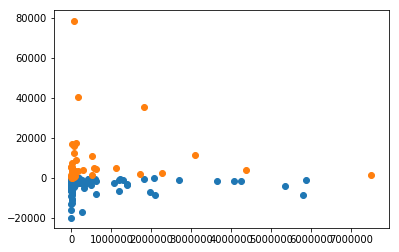

In [143]:
#Look at the distribution of losss and losses
x_loss = useful_trades[loss_perc_useful_mask].trade_duration.values
y_loss = useful_trades[loss_perc_useful_mask].realized.values
y_loss = y_loss.astype(np.int64)
y_loss = (np.sort(y_loss,axis=-1))
# print(y_loss)
plt.scatter(x_loss,y_loss) 
# win distribution
x_win = useful_trades[win_perc_useful_mask].trade_duration.values
y_win = useful_trades[win_perc_useful_mask].realized.values
y_win = y_win.astype(np.int64)
y_win = (np.sort(y_win,axis=-1))
# print(y_win)
plt.scatter(x_win,y_win) 

## Check duration distribution by 2hrs,1hr,30min etc.

In [144]:
dur_list = [7200,3600,1800,900,450,225,60]
for dur in dur_list:
    duration_mask = (pd.to_numeric(useful_trades['trade_duration']) < dur)
    print(useful_trades[duration_mask].shape[0]/useful_trades.shape[0])

0.6942675159235668
0.6151804670912951
0.5265392781316348
0.46125265392781317
0.37579617834394907
0.2940552016985138
0.14171974522292993


## Compute general metrics

In [145]:
# date range
first_day = parser.parse(trades.opendt.values[-1])
last_day = parser.parse(trades.opendt.values[0])
print('time period',first_day - last_day)
# how many trades per day
average_trades_per_day = 0
unique_days = 1
day_count = 0
current_day = parser.parse(trades.opendt[0])
for row in trades.opendt:
    day = parser.parse(row)
    if day.day == current_day.day:
        day_count += 1
    else:
        average_trades_per_day += day_count
        current_day = day
        day_count = 0
        unique_days += 1
average_trades_per_day = average_trades_per_day / unique_days
print('average_trades_per_day',average_trades_per_day)
# average trade length
print('number of trades',trades.shape[0])
trade_times = []
for idx in range(trades.shape[0]):
    trade_open = parser.parse(trades.opendt[idx])
    trade_close = parser.parse(trades.closedt[idx])
    trade_time = trade_close - trade_open
    trade_times.append(trade_time)
durations = [h.total_seconds() for h in trade_times]

# trade length is correlated with winning % because:
# 1. stop losses are closer to the price than when exited a winning trade. 
#   This is because Ryan imploys a 3:1 win/loss strategy (aprox)
# 2. the longer you haven't triggered the stop loss, the more likely the stock is to have move in your direction


time period 490 days, 23:00:32
average_trades_per_day 11.392712550607287
number of trades 3062


In [146]:
# Not that many repeated durations. Although they mainly center around 0
duration_counts_dict = {}
duration_counts = []
unique_durations = set(durations)
print('number of unqiue trade durations',len(unique_durations))
print('vs number of total durations',len(durations))
for duration in unique_durations:
    temp_count = durations.count(duration)
    duration_counts.append(temp_count)
    duration_counts_dict[duration] = temp_count
    

number of unqiue trade durations 2187
vs number of total durations 3062


In [147]:
print('Longest trade',max(trade_times))
print('Shortest trade',min(trade_times))
print('Mean trade',np.sum(trade_times)/len(trade_times))

Longest trade 214 days, 20:44:22
Shortest trade 0:00:00
Mean trade 1 day, 23:34:39.645003


523356819.0
523356819.0
(2187,) (2187,)


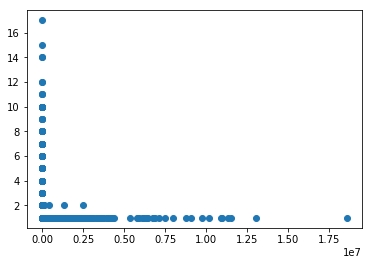

In [148]:
#displaying duration length vs frequency of occurance
y = np.array(list(duration_counts_dict.values()))
x = np.array(sorted(list(duration_counts_dict.keys())))
print(sum(sorted(list(duration_counts_dict.keys()))))
print(sum(sorted(list(duration_counts_dict.keys()))))
print(x.shape,y.shape)
plt.scatter(x,y) 

### Breaking down Swing trades by sector and industry and volatility

We can see what stocks he trades in each industry and sector. And also grab some general stats about them, like how well he does and what the sample size is. Current this is by Swing_trades. But can be used for any of the data slices.

**Volatility is broken down into 3 segments:**
+ Monthly Volatility taken from Finviz
+ Hilo Volatility computed by (stock_high - stock_low) / average_entry_price
+ Volatility computed by atr14 / average_entry_price

In [149]:
sector_dict = {}
industry_dict = {}
volatility_dict = {}
volatility_finviz_dict = {}
volatility_hilo_dict = {}
# Swap this out to get industry/sector for any dataset
for index, row in swing_trades.iterrows():
#     try:
    stock_index = get_stock_index(row[2])
    stock = finviz.loc[stock_index]
    quantity = row[3]
    result = row[6]
    average_entry_price = row[9]
    stock_high = row[32]
    stock_low = row[33]
    atr14 = row[37]
    ## Volatility data
    volatility_finviz = float(stock['Volatility (Month)'])
    volatility_trade = atr14 / average_entry_price
    volatility_trade_hilo = (stock_high - stock_low) / average_entry_price
    ## Sector and Industry data 
    if stock.Sector in sector_dict:
        sector_dict[stock.Sector]['result'] += result
        sector_dict[stock.Sector]['count'] += 1
        sector_dict[stock.Sector]['quantity'] += quantity
#         np.vstack((sector_dict[stock.Sector]['trades'],row.values))
        sector_dict[stock.Sector]['trades'].append(row)
    else:
        print(stock.Sector)
        sector_dict[stock.Sector] = {'result':result, 'count':1,'quantity':quantity,'trades':[row]}
    if stock.Industry in industry_dict:
        industry_dict[stock.Industry]['result'] += result
        industry_dict[stock.Industry]['count'] += 1
        industry_dict[stock.Industry]['quantity'] += quantity
        industry_dict[stock.Industry]['trades'].append(row)
    else:
        industry_dict[stock.Industry] = {'result':result, 'count':1,'quantity':quantity,
                                         'trades':[row]}
    ###
    finviz_key = hash(round(volatility_finviz, 1))
    volatility_key = hash(round(volatility_trade, 4))
    hilo_key = hash(round(volatility_trade_hilo, 4))
    if finviz_key in volatility_finviz_dict:
        volatility_finviz_dict[finviz_key]['result'] += result
        volatility_finviz_dict[finviz_key]['count'] += 1
    else:
        volatility_finviz_dict[finviz_key] = {'result':result,'volatility':volatility_finviz,'count':1}
    ## Vanila volatility
    if volatility_key in volatility_dict:
        volatility_dict[volatility_key]['result'] += result
        volatility_dict[volatility_key]['count'] += 1
    else:
        volatility_dict[volatility_key] = {'result':result,'volatility':volatility_trade,'count':1}
    ## hilo volatility
    if hilo_key in volatility_hilo_dict:
        volatility_hilo_dict[hilo_key]['result'] += result
        volatility_hilo_dict[hilo_key]['count'] += 1
    else:
        volatility_hilo_dict[hilo_key] = {'result':result,'volatility':volatility_trade_hilo,'count':1}
#     except:
#         pass

Services
Technology
Consumer Goods
Industrial Goods


## Check particular sector or industry

In [150]:
print(sector_dict.keys())
print(sector_dict['Technology'].keys())
print(len(sector_dict['Technology']['trades']))

dict_keys(['Services', 'Technology', 'Consumer Goods', 'Industrial Goods'])
dict_keys(['result', 'count', 'quantity', 'trades'])
366


## Gather volatility metrics for display

In [151]:
# print(volatility_finviz_dict)
# for key,value in enumerate(sector_dict):
#     print(sector_dict[value])
## Volatility
# [print(volatility_finviz_dict[value]) for key,value in enumerate(volatility_finviz_dict)]
volatility_finviz_y = [volatility_finviz_dict[value]['result']/volatility_finviz_dict[value]['count'] for key,value in enumerate(volatility_finviz_dict)]
volatility_finviz_x = [volatility_finviz_dict[value]['volatility'] for key,value in enumerate(volatility_finviz_dict)]
volatility_y = [volatility_dict[value]['result']/volatility_dict[value]['count'] for key,value in enumerate(volatility_dict)]
volatility_x = [volatility_dict[value]['volatility'] for key,value in enumerate(volatility_dict)]
volatility_hilo_y = [volatility_hilo_dict[value]['result']/volatility_hilo_dict[value]['count'] for key,value in enumerate(volatility_hilo_dict)]
volatility_hilo_x = [volatility_hilo_dict[value]['volatility'] for key,value in enumerate(volatility_hilo_dict)]
## Sector and industry
sector_y = [sector_dict[value]['result']/sector_dict[value]['count'] for key,value in enumerate(sector_dict)]
sector_x = [value for key,value in enumerate(sector_dict)]
industry_y = [industry_dict[value]['result']/industry_dict[value]['count'] for key,value in enumerate(industry_dict)]
industry_x = [value for key,value in enumerate(industry_dict)]

## Calculate average return,std and stock names for all sectors

In [152]:
for sector in sector_dict:
    print(sector)
    results = []
    quantities = []
    stock_names = {}
    stocks = []
    for trade in sector_dict[sector]['trades']:
        results.append(int(trade.realized))
        quantities.append(int(trade.quantity))
        symbol = trade.symbol
        if symbol not in stock_names:
            stocks.append(symbol)
            stock_names[symbol] = 1
    per_share = [results[idx] / quantities[idx] for idx in range(len(results))]
    results = sorted(results)
    #Clip outliers
    if results[-1] > 2 * results[-2]:
        del results[-1]
    if results[0] < 2 * results[1]:
        del results[0]
#     print(results[-5:])
#     print(results[:5])
#     print('total result',sum(results))
    sector_result = sum(results) / sector_dict[sector]['quantity']
#     print('per share',sector_result)
    print('mean return',sum(per_share)/len(per_share))
    print('std',np.std(np.array(per_share)))
    print('mad',mad(per_share))
    print(stocks)

Services
mean return 0.033413248632603976
std 1.4866219826462697
mad 0.908184817272855
['KR', 'TITN', 'NFLX', 'CNET', 'NXTD', 'WTW', 'PFMT', 'TSG', 'CATM', 'BOOT', 'VIAB', 'EXPE', 'WBA', 'SHAK', 'UEPS', 'VRSK', 'ROKU', 'QUAD', 'CAKE', 'CAR', 'STN', 'GNC', 'HTZ', 'WBAI', 'DESP', 'SPEX', 'SIG', 'TLRD', 'HUD', 'BABA', 'BKS', 'BKE', 'FIVE', 'OMEX', 'BGI', 'BBBY', 'KTOS', 'SPOT', 'IMTE', 'COST', 'BLNK', 'SGMS', 'PENN', 'BYD', 'IGT', 'HD', 'AMCX', 'OMC', 'GPS', 'LABL', 'TLYS', 'CARS', 'JILL', 'EXPR', 'BIG', 'DDE', 'HUYA', 'WEN', 'MTN', 'SFIX', 'CONN', 'CHTR', 'ETSY', 'DIS', 'ULTA', 'GME', 'NEW', 'SBUX', 'DPZ', 'DNKN', 'CMG', 'ROST', 'YVR', 'IPG', 'WWE', 'MMYT', 'FISV', 'CMCSA', 'MGM', 'CZR', 'WYNN', 'TIVO', 'TPNL', 'HYRE', 'AQ', 'RBZ', 'CECO', 'CVNA', 'PZZA', 'HMHC', 'LYV', 'CTRP', 'HCSG', 'TECD', 'MGA', 'FLNT', 'FRSH', 'SCVL', 'ARCI', 'LOW', 'ADS']
Technology
mean return 0.29200775612959173
std 2.465346304831681
mad 1.27250623412963
['FB', 'SQ', 'FNSR', 'DPW', 'XNET', 'QD', 'GOOG', 'NTNX', 

## Checking overnight percentages

In [153]:
held = 0
not_held = 0
total_held = 0 
for trade in sector_dict['Services']['trades']:
    if trade['held_overnight'] == 1:
        held += 1
    else:
        not_held += 1

total_held = held + not_held
print('ratio of held_overnight vs not',held / total_held ,not_held / total_held)
print('actual occurances',held,not_held)

ratio of held_overnight vs not 0.44808743169398907 0.5519125683060109
actual occurances 82 101


### Correlations

Now look at correlations across industries. I have these saved to a folder for deeper inspection. You can't see much here but you can tell there are some hot spots. Primarily we are interested in the correlations for *percent_gain* and *per_share_return*. 
For example:
They are positively correlated with volume. This makes sense as high volume makes day trading easier, as you don't move the price and the margin between bid and ask is small. Additionally high volume is a marker of action in a stock, which is why a day trader would be there in the first place.

In [154]:
# formula for displaying and saving correlation matricies
def save_correlations(dictionary,path):
    count = 1
    for industry in dictionary:
        results = []
        quantities = []
        stock_names = {}
        stocks = []
        for trade in dictionary[industry]['trades']:
            results.append(trade.realized)
            quantities.append(trade.quantity)
            symbol = trade.symbol
            if symbol not in stock_names:
                stocks.append(symbol)
                stock_names[symbol] = 1
        per_share = [results[idx] / quantities[idx] for idx in range(len(results))]
        results = sorted(results)
        if len(results) > 25:
            print(industry)
            if results[-1] > 2 * results[-2]:
                del results[-1]
            if results[0] < 2 * results[1]:
                del results[0]
            sector_result = sum(results) / dictionary[industry]['quantity']
            corr = pd.DataFrame(dictionary[industry]['trades'])
            labels = list(corr.columns)
            cmap = 'coolwarm'
            corr.style.background_gradient(cmap, axis=1)\
                .set_properties(**{'max-width': '500px', 'font-size': '50pt'})\
                .set_caption("Hover to magify")\
                .set_precision(2)\
                .set_table_styles(magnify())
            csv_file = corr.corr()
            # Comment this out so that it works on any computer
#             csv_file.to_csv(path + industry + '.csv')
            plt.figure(num=count, figsize=(16, 16), dpi=40, facecolor='w', edgecolor='k')
            plt.matshow(corr.corr(method='pearson', min_periods=1),fignum=count)
            plt.show()
            count += 1
            
def save_show_correlations(data,path,name):
    labels = list(data.columns)
    cmap = 'coolwarm'
    trades.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '500px', 'font-size': '50pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(magnify())
    csv_file = data.corr()
    csv_file.to_csv(path +'/'+ name +'.csv')
    plt.figure(num=0,figsize=(16, 16), dpi=40, facecolor='w', edgecolor='k')
    plt.matshow(data.corr(method='pearson', min_periods=1),fignum=0)
    plt.show()
    
def return_top10(data,column):
    sorted_gains = sorted(data[column].values)
    sorted_gains = [gain for gain in sorted_gains if gain.round(3) != 1 and np.isnan(gain) == False]
    bot_ten_gains = sorted_gains[:20]
    top_ten_gains = sorted_gains[-20:]
    return top_ten_gains,bot_ten_gains

def return_column_names(data,li,column):
    cols = []
    for num in li:
#         print('details',num,column,np.where(data[column] == num))
        index = np.where(data[column] == num)[0][0] + 1
        cols.append(data.columns[index])
    return cols
    
def display_correlation_values(file_path):
    # Gather and show the top 10 bot 10 correlations for the target features
    # percent gain
    data_corr = pd.read_csv(file_path)
    print(data_corr.columns,data_corr.shape)
    top_ten_gains,bot_ten_gains = return_top10(data_corr,'percent_gain')
    positive_gain_cols = return_column_names(data_corr,top_ten_gains,'percent_gain')
    negative_gain_cols = return_column_names(data_corr,bot_ten_gains,'percent_gain')
    show_negatives = list(zip(negative_gain_cols,bot_ten_gains))
    show_positives = list(zip(positive_gain_cols,top_ten_gains))
    print('positive_cols \n',positive_gain_cols)
    print('negative_cols \n',negative_gain_cols)
    print('Positive gain columns \n',show_positives,'Negative gain columns \n',show_negatives)
    # per_share_return
    top_ten_share,bot_ten_share = return_top10(data_corr,'per_share_return')
    positive_share_cols = return_column_names(data_corr,top_ten_share,'per_share_return')
    negative_share_cols = return_column_names(data_corr,bot_ten_share,'per_share_return')
    show_share_negatives = list(zip(negative_share_cols,bot_ten_share))
    show_share_positives = list(zip(positive_share_cols,top_ten_share))
    print('positive_cols \n',positive_share_cols,'\n')
    print('negative_cols \n',negative_share_cols,'\n')
    print('Positive share columns \n',show_share_positives,'\n','Negative share columns \n',show_share_negatives)

## Show and save correlation matricies by sector and industry

By Industry
Internet Information Providers


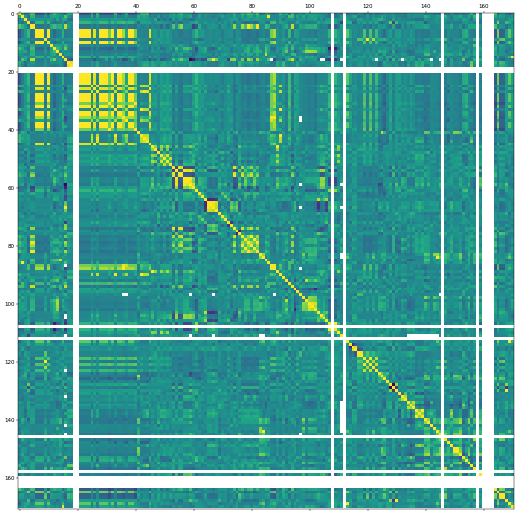

CATV Systems


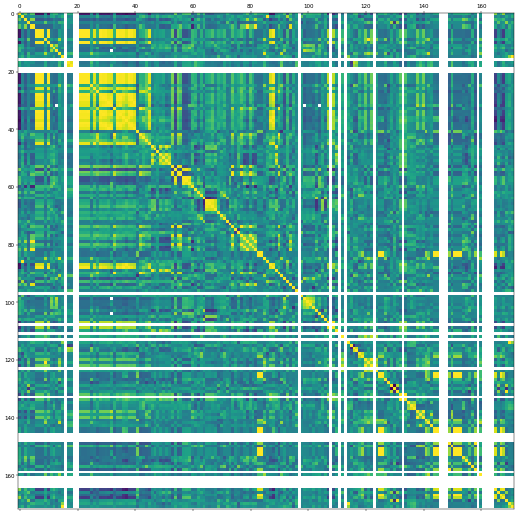

Internet Software & Services


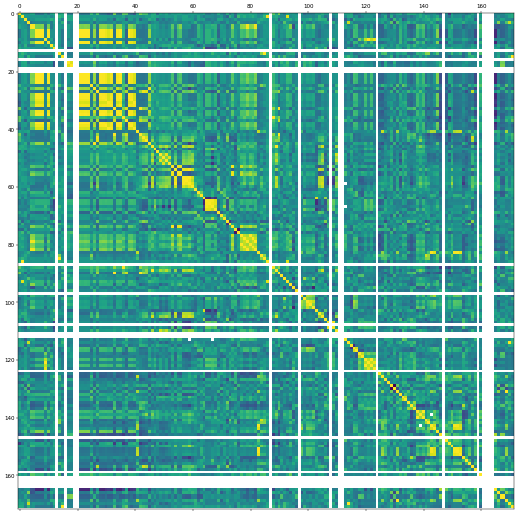

Communication Equipment


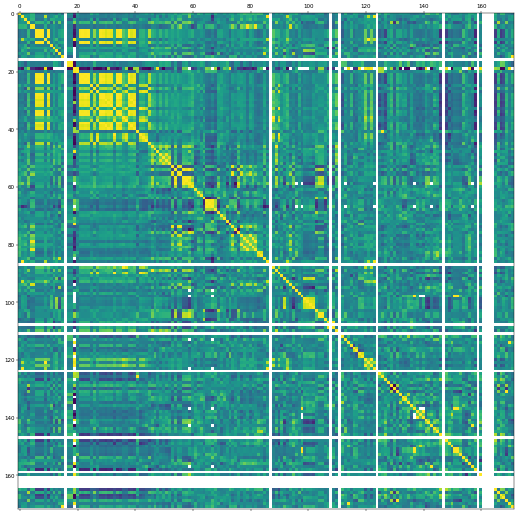

Application Software


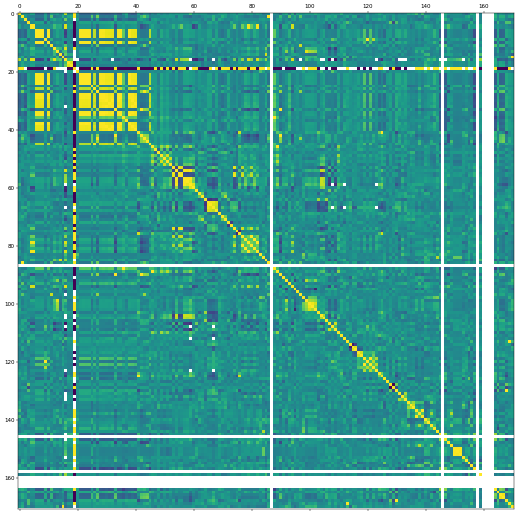

Auto Manufacturers - Major


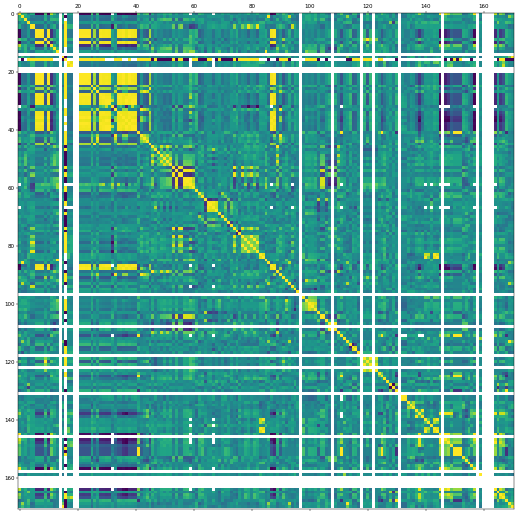

By Sector
Services


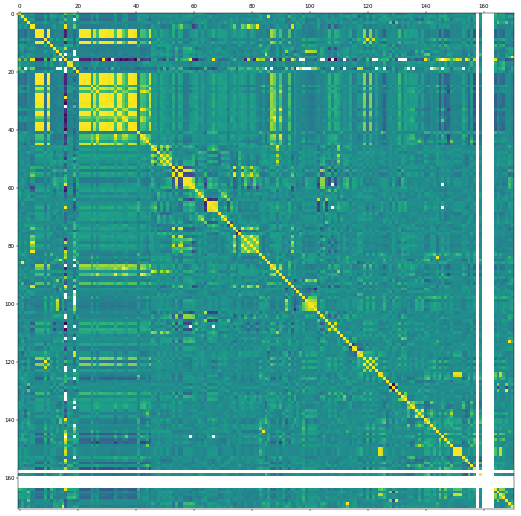

Technology


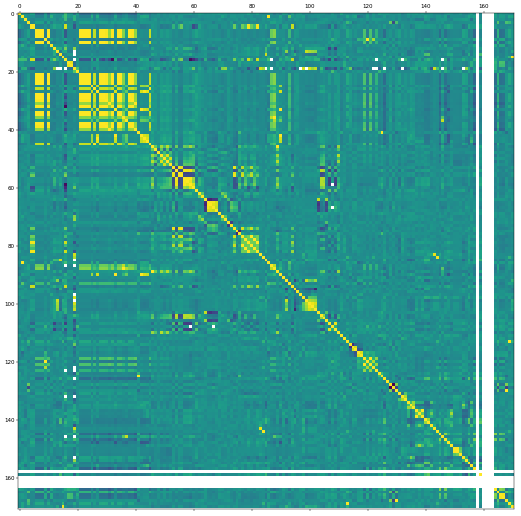

Consumer Goods


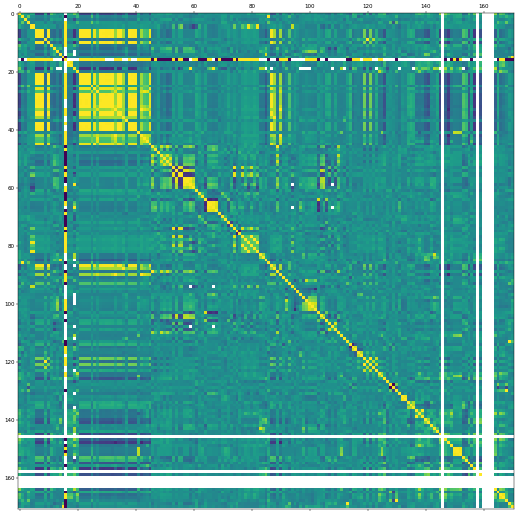

In [155]:
industry_path = '/Users/morgan/Documents/Ryan_correlations/Industry/'
sector_path = '/Users/morgan/Documents/Ryan_correlations/Sector/'
print('By Industry')
save_correlations(industry_dict,industry_path)
print('By Sector')
save_correlations(sector_dict,sector_path)

## Save correlation matricies for the following data slices

+ trades
+ useful_trades
+ shorts
+ longs
+ win
+ loss

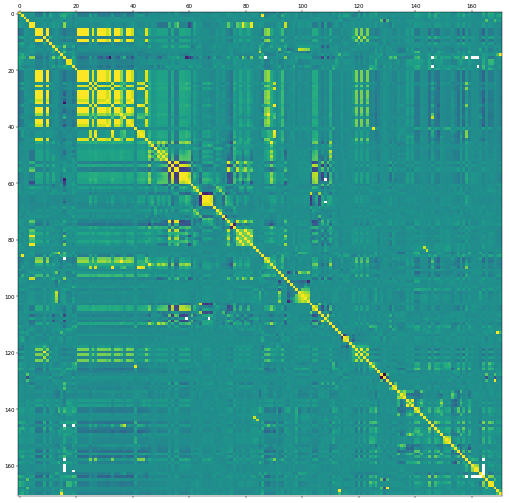

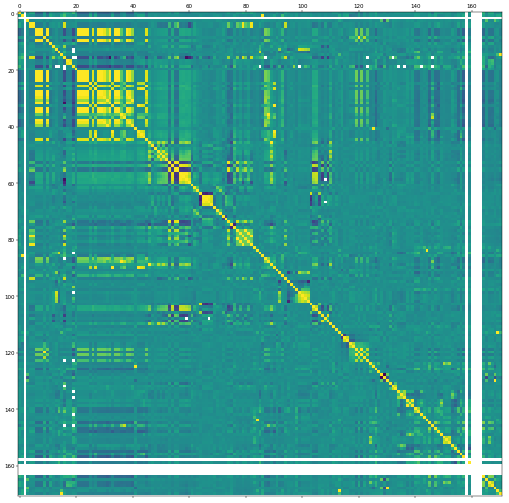

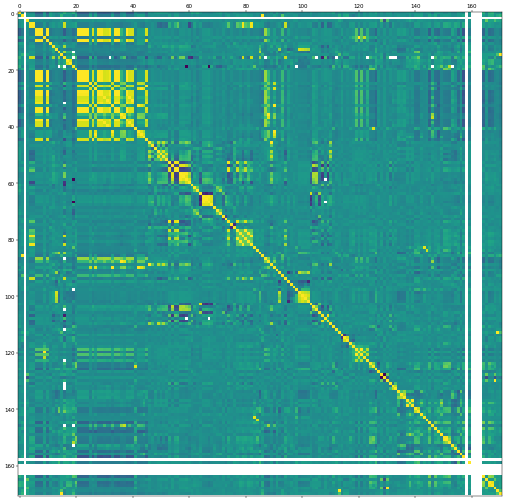

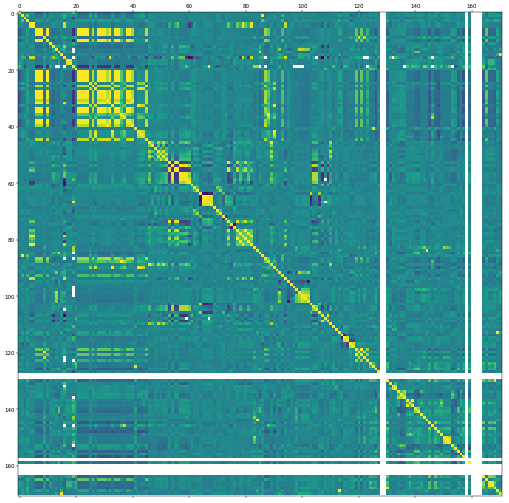

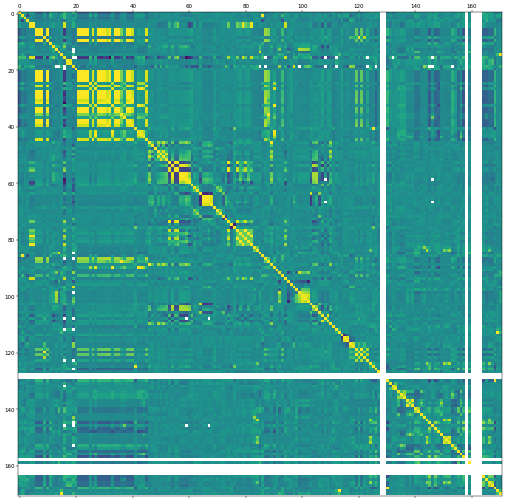

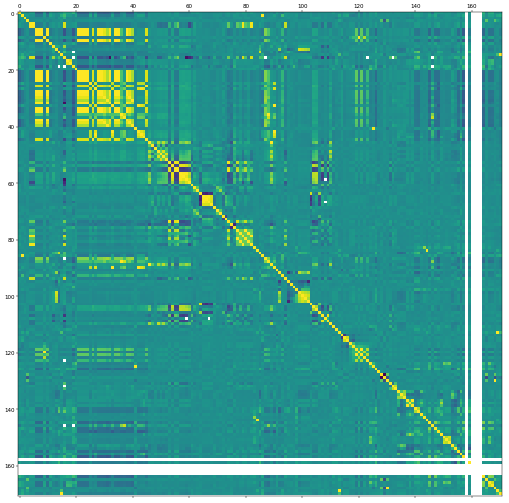

In [156]:
path = '/Users/morgan/Documents/Ryan_correlations/Overall'
name = 'Overall_correlations'
save_show_correlations(trades,path,name)
long_path = '/Users/morgan/Documents/Ryan_correlations/Longs'
short_path = '/Users/morgan/Documents/Ryan_correlations/Shorts'
short_name = 'shorts_correlations'
long_name = 'longs_correlations'
save_show_correlations(long_df,long_path,long_name)
save_show_correlations(short_df,short_path,short_name)
win_name = "useful_wins"
loss_name = "useful_losses"
useful_path = '/Users/morgan/Documents/Ryan_correlations/Overall'
save_show_correlations(win_df,useful_path,win_name)
save_show_correlations(loss_df,useful_path,loss_name)
useful_path = '/Users/morgan/Documents/Ryan_correlations/Overall'
useful_name = 'useful_trades_correlations'
save_show_correlations(useful_trades,useful_path,useful_name)

## Display the correlation data based on percent gain and per share return

In [157]:
#Look at the correlation data
short_path = '/Users/morgan/Documents/Ryan_correlations/Overall/Overall_correlations.csv'
display_correlation_values(short_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'lev', 'is_lev', 'use?', 'finviz_vol', 'per_share_return',
       'atr14_percent', 'atr14_lag_percent', 'percent_gain', 'trade_duration',
       'held_overnight'],
      dtype='object', length=172) (171, 172)
positive_cols 
 ['lo_vol', 'timeSum', 'atr14_percent', 'mvol_ptile50_lag', 'tradetype', 'ay_ratio', 'vixpc_ret', 'mvol_ptile200_lag', 'ycv_crazy', 'vol_amp', 'avg_up', 'volume', 'vixpc_cl', 'earn_season', 'acv_crazy', 'volspike', 'voljump30', 'per_share_return', 'realized', 'wintrade']
negative_cols 
 ['losstrade', 'lastExSize', 'prclose_chg', 'ovn_chg', 'halt_reopen_elapse', 'finviz_vol', 'is_long', 'avg_dn', 'trade_duration', 'holdmins', 'ipo_trade_day', 'postvolspike', 'momo', 'avg_type', 'lo_price', 'voljump30_dn', 'voldayjump', 'vol_reverse', 'ycv_dn', 'acv_dn']
Positive gain columns 
 [

In [158]:
long_path = '/Users/morgan/Documents/Ryan_correlations/Longs/longs_correlations.csv'
display_correlation_values(long_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'lev', 'is_lev', 'use?', 'finviz_vol', 'per_share_return',
       'atr14_percent', 'atr14_lag_percent', 'percent_gain', 'trade_duration',
       'held_overnight'],
      dtype='object', length=172) (171, 172)
positive_cols 
 ['mvol_chg', 'spy_ovn', 'posttrade', 'volspike', 'acv_gte_ycv', 'vixpc_cl', 'yestvoljump', 'spy_adj_ret', 'avg_up', 'vixpc_ret', 'yest_gte_adv', 'acv_crazy', 'acv_atr', 'tradetype', 'spy_ret_lag', 'spyUp', 'volume', 'realized', 'per_share_return', 'wintrade']
negative_cols 
 ['losstrade', 'spy10_lag', 'spy10', 'vxst_cl', 'spy50', 'spy200', 'spy200_lag', 'spy50_lag', 'vix_ret_lag', 'spy_adj_cl_lag', 'idsym', 'vvix_ret', 'vix_ret', 'acv_per', 'vix_ovn', 'vxv_ret', 'spy_adj_cl', 'spy_op', 'mvol_ptile50_lag', 'spy_cl']
Positive gain columns 
 [('mvol_chg', 0.03700026543233143), ('

In [159]:
useful_path = '/Users/morgan/Documents/Ryan_correlations/Overall/useful_trades_correlations.csv'
display_correlation_values(useful_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'lev', 'is_lev', 'use?', 'finviz_vol', 'per_share_return',
       'atr14_percent', 'atr14_lag_percent', 'percent_gain', 'trade_duration',
       'held_overnight'],
      dtype='object', length=172) (171, 172)
positive_cols 
 ['spy_ret_lag', 'earn_season', 'avg_up', 'yest_gte_adv', 'open_chg', 'tradetype', 'holdmins', 'trade_duration', 'ovntrade', 'held_overnight', 'vol_amp', 'volume', 'first_ex_50p', 'yestvoljump', 'volspike', 'acv_crazy', 'ay_ratio', 'realized', 'per_share_return', 'wintrade']
negative_cols 
 ['losstrade', 'ovn_chg', 'prclose_chg', 'lastExSize', 'halt_reopen_elapse', 'voljump', 'avg_dn', 'lo_price', 'avg_type', 'finviz_vol', 'cb_day', 'atr14_lag_percent', 'spy10_lag', 'spy10', 'cb_flag', 'voljump30_dn', 'voldayjump', 'ipo_trade_day', 'both_dn', 'ycv_dn']
Positive gain columns 
 [

In [160]:
win_path = '/Users/morgan/Documents/Ryan_correlations/Overall/useful_wins.csv'
display_correlation_values(win_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'lev', 'is_lev', 'use?', 'finviz_vol', 'per_share_return',
       'atr14_percent', 'atr14_lag_percent', 'percent_gain', 'trade_duration',
       'held_overnight'],
      dtype='object', length=172) (171, 172)
positive_cols 
 ['yest_gte_adv', 'acv_gte_ycv', 'yestvoljump', 'voldayjump', 'ycv_crazy', 'vol_amp', 'per_share_return', 'ay_ratio', 'voljump30', 'lo_vol', 'voljump', 'lo_atr', 'volspike', 'acv_crazy', 'halt_flag', 'atr14_lag_percent', 'atr14_percent', 'lo_price', 'lo_mc', 'finviz_vol']
negative_cols 
 ['lo52w', 'lo52w_lag', 'pr_close', 'sma10', 'open', 'low', 'hi30d', 'firstEntPrice', 'close', 'lastExPrice', 'high', 'lo30d', 'average_exit_price', 'average_entry_price', 'hi52w_lag', 'hi52w', 'sma50', 'sma200', 'atr14_lag', 'atr14']
Positive gain columns 
 [('yest_gte_adv', 0.10486394450579796

In [161]:
loss_path = '/Users/morgan/Documents/Ryan_correlations/Overall/useful_losses.csv'
display_correlation_values(loss_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'lev', 'is_lev', 'use?', 'finviz_vol', 'per_share_return',
       'atr14_percent', 'atr14_lag_percent', 'percent_gain', 'trade_duration',
       'held_overnight'],
      dtype='object', length=172) (171, 172)
positive_cols 
 ['atr14', 'sma200', 'lo30d', 'atr14_lag', 'hi52w', 'hi52w_lag', 'high', 'open', 'low', 'firstEntPrice', 'close', 'average_entry_price', 'pr_close', 'sma50', 'sma10', 'average_exit_price', 'lastExPrice', 'hi30d', 'lo52w', 'lo52w_lag']
negative_cols 
 ['ovn_chg', 'prclose_chg', 'bigmove', 'open_chg', 'ent_size_z', 'timeNum', 'add_liq', 'prePost', 'premkt', 'newHi', 'timeSum', 'hour', 'spy_ret_oc', 'first_ex_per', 'holdmins', 'vixBack', 'momo', 'mvolB', 'newLo', 'spyTrendDn']
Positive gain columns 
 [('atr14', 0.3130434098428426), ('sma200', 0.3159622500196352), ('lo30d', 0.31835

## Correlations for percent_gain and per_share_return

Some correlations are always directly related to the target (Realized, trade_return etc.). We can get rid of the those results and get to ones that are more interesting. One hypothesis that Ryan has is lower volatility is correlated with performance.

## Trades:
#### Percent_gain

Positive Correlations

+ timeSum, 0.023,
+ atr14_percent, 0.024,
+ mvol_ptile50_lag, 0.025,
+ tradetype, 0.026,
+ ay_ratio, 0.030,
+ vixpc_ret, 0.031,
+ mvol_ptile200_lag, 0.035,
+ ycv_crazy, 0.035,
+ vol_amp, 0.036,
+ avg_up, 0.043,
+ volume, 0.043,
+ vixpc_cl, 0.044,
+ earn_season, 0.047,
+ acv_crazy, 0.051,
+ volspike, 0.060,
+ voljump30, 0.093,

Negative Correlations

+ prclose_chg, -0.082,
+ ovn_chg, -0.081,
+ halt_reopen_elapse, -0.068,
+ is_long, -0.060,
+ avg_dn, -0.052,
+ trade_duration, -0.050,
+ holdmins, -0.050,
+ ipo_trade_day, -0.048,
+ postvolspike, -0.045,
+ momo, -0.042,
+ avg_type, -0.038,
+ lo_price, -0.035,
+ voljump30_dn, -0.031,
+ voldayjump, -0.031,
+ vol_reverse, -0.027,
+ ycv_dn, -0.025,
+ acv_dn, -0.024,
+ vix_ovn, -0.022,

Percent_gain is positively correlated with:
Vix (volatility): (vixpc_ret,vixpc_cl)
Volume: (volume,vol_amp)
Earnings: (earn_season)

Negatively Correlated with:
Overnight change:
If things go south overnight, Ryan is likely to get out at a loss. Otherwise he will continue holding.

prclose_chg,ovn_chg: overnight change and prior to close change, would both potentially negatively effect long term holding strategies. Its likely that stocks have big down moves more often than big up moves in this time periods.

halt_reopen_elapse: How long the stock has been halted for. Ryan has one big outlier loss for this (PCG).
This is a special case. Could see how many instances of this there actually are. Ryan may have just been unlucky here.

is_long. I suspect this is because when Ryan is long, he typically holds for 3x gain. and thus often will lose. Although in the long run this has shown to be effective. So it should still be a positive connection.

avg_dn

trade_duration/holdmins: This suggests that his big gains are correlated with fast moving stocks as opposed to long term holds.

postvolspike,momo: Suggest Fomo for missing out on a move.
Postvolspike: if the move is less than the prior day vol spike and today's vol is less than yesterday's volume.

Vix:

Positive:
vixpc_cl
Negative:
vix_ovn

#### Per_share_return

Positive correlations

+ vol_amp, 0.032,
+ timeSum, 0.032,
+ acv_crazy, 0.032,
+ postmkt, 0.033,
+ bigmove, 0.034,
+ prePost, 0.038,
+ mv, 0.040,
+ add_liq, 0.041,
+ earntrade, 0.044,
+ trade_duration, 0.049,
+ holdmins, 0.049,
+ earn_season, 0.052,
+ volspike, 0.058,
+ avg_up, 0.060,
+ held_overnight, 0.068,
+ ovntrade, 0.071,

Negative correlations

+ avg_dn, -0.09,
+ avg_type, -0.08,
+ momo, -0.04,
+ postvolspike, -0.04,
+ voljump30_dn, -0.03,
+ acv_dn, -0.03,
+ vix_ovn, -0.03,
+ halt_reopen_elapse, -0.02,
+ both_dn, -0.02,
+ vxst_ret, -0.02,
+ ycv_dn, -0.02,
+ lastExSize, -0.02,
+ atr14_lag, -0.02,
+ is_long, -0.02,
+ open_mv, -0.02,
+ ent_mv_z, -0.02,
+ second_time, -0.01,
+ hiVix, -0.01,
+ lo_price, -0.01,

Per_share performance is positively correlated with 
Duration. (ovntrade,held_overnight,holdmins,trade_duration)
Volume. (add_liq,volspike,mv,bigmove,vol_amp,acv_crazy)
Earnings. (earntrade,earn_season)
Momentum. (mv,avg_up)
Outside normal market hours. (postmkt,prePost)
timesum,acv_crazy(?)

Negatively correlated with:
avg_dn
avg_type
momo
postvolspike

Vix:
positive:
None
Negative:
hiVix
vxst_ret
vix_ovn

## Useful Trades

#### Positive gain columns 
+ earn_season, 0.039,
+ avg_up, 0.043,
+ yest_gte_adv, 0.043,
+ open_chg, 0.045,
+ tradetype, 0.045,
+ holdmins, 0.046,
+ trade_duration, 0.046,
+ ovntrade, 0.046,
+ held_overnight, 0.047,
+ vol_amp, 0.047,
+ volume, 0.053,
+ first_ex_50p, 0.055,
+ yestvoljump, 0.056,
+ volspike, 0.070,
+ acv_crazy, 0.079,
+ ay_ratio, 0.082,

#### Negative gain columns 
+ ovn_chg, -0.197,
+ prclose_chg, -0.187,
+ lastExSize, -0.094,
+ halt_reopen_elapse, -0.093,
+ voljump, -0.084,
+ avg_dn, -0.079,
+ lo_price, -0.077,
+ avg_type, -0.075,
+ finviz_vol, -0.0634
+ cb_day, -0.059,
+ atr14_lag_percent, -0.059,
+ spy10_lag, -0.054,
+ spy10, -0.053,
+ cb_flag, -0.052,
+ voljump30_dn, -0.046,
+ voldayjump, -0.043,
+ ipo_trade_day, -0.042,
+ both_dn, -0.042,
+ ycv_dn, -0.041,
+ acv_dn, -0.039,

#### Positive share columns 
+ acv_atr, 0.045,
+ lo_vol, 0.047,
+ earn_season, 0.048,
+ vol_amp, 0.049,
+ mvol, 0.052,
+ mvolB, 0.052,
+ add_liq, 0.054,
+ first_ex_50p, 0.054,
+ acv_crazy, 0.056,
+ avg_up, 0.059,
+ volspike, 0.072,
+ held_overnight, 0.105,
+ ovntrade, 0.112,
+ holdmins, 0.170,
+ trade_duration, 0.170,

#### Negative share columns 
+ halt_reopen_elapse, -0.237,
+ avg_dn, -0.107,
+ avg_type, -0.101,
+ voljump30_dn, -0.054,
+ lastExSize, -0.047,
+ momo, -0.044,
+ second_time, -0.036,
+ ent_mv_z, -0.032,
+ open_mv, -0.032,
+ spyTrendUp, -0.031,
+ acv_dn, -0.028,
+ skew_cl, -0.028,
+ big_ent_mv, -0.028,
+ ovn_chg, -0.027,
+ prclose_chg, -0.027,
+ both_dn, -0.025,
+ ycv_dn, -0.024,
+ trend_up, -0.024,
+ vix_ovn, -0.024,

# Swing trades

## Wins

Keep in mind in wins (and in vice versa in losses), there are no losses. So correlations are just about how big or small the win is. that is, positive columns amplify wins, negative columns temper wins.

#### Positive gain columns 
+ acv_gte_ycv, 0.072,
+ trade_duration, 0.094,
+ yestvoljump, 0.095,
+ voldayjump, 0.140,
+ ycv_crazy, 0.161,
+ vol_amp, 0.169,
+ held_overnight, 0.172,
+ ay_ratio, 0.216,
+ volspike, 0.231,
+ voljump, 0.251,
+ voljump30, 0.264,
+ lo_atr, 0.273,
+ lo_vol, 0.275,
+ acv_crazy, 0.283,
+ atr14_lag_percent, 0.385,
+ lo_price, 0.446,
+ lo_mc, 0.465,
+ atr14_percent, 0.478,
+ finviz_vol, 0.519

Duration.
Volume. 
Atr: percent,lag_percent
lo_price: Buy the dip! this is probably due to being able to maximize distance for gains by starting low.

#### Negative gain columns 
+ lo52w, -0.313,
+ lo52w_lag, -0.311,
+ pr_close, -0.272,
+ low, -0.272,
+ open, -0.271,
+ firstEntPrice, -0.269,
+ close, -0.269,
+ sma10, -0.269,
+ lastExPrice, -0.269,
+ average_entry_price, -0.268,
+ lo30d, -0.268,
+ high, -0.268,
+ average_exit_price, -0.268,
+ hi52w_lag, -0.267,
+ hi52w, -0.267,
+ hi30d, -0.267,
+ sma50, -0.259,
+ sma200, -0.251,
+ atr14_lag, -0.226,
+ fang, -0.226,

Stock price: (firstEntPrice,average_entry_price) Not sure what this means

#### Positive share columns 
+ yestvoljump, 0.009,
+ ay_ratio, 0.016,
+ vol_reverse, 0.026,
+ acv_crazy, 0.028,
+ vol_amp, 0.034,
+ lo_vol, 0.051,
+ held_overnight, 0.090,
+ acv_gte_ycv, 0.107,
+ yest_gte_adv, 0.114,
+ acv_atr, 0.126,
+ trade_duration, 0.204,

Not many positive share columns here. 

#### Negative share columns 
+ halt_reopen_elapse, -0.346,
+ idsym, -0.129,
+ quantity, -0.128,
+ ipo_trade_day, -0.126,
+ lastExSize, -0.119,
+ firstEntSize, -0.109,
+ ent_size_z, -0.109,
+ vol30, -0.097,
+ vol30_lagM, -0.097,
+ vol30_lag, -0.097,
+ spy_adj_cl, -0.095,
+ float, -0.093,
+ vol5_lag, -0.092,
+ vol5, -0.088,
+ spy_adj_cl_lag, -0.087,
+ spy_cl, -0.087,
+ big_ent_size, -0.080,
+ vol_lag, -0.075,
+ volume, -0.074,

Quantity is slightly correlated with smaller wins. This is consistent to other observations that quantity is (very) slightly negatively correlated.
IPOs.

## Losses

Positive columns indicate features that temper losses. Negative columns amplify losses

#### Positive gain columns 
+ atr14_lag, 0.241,
+ sma50, 0.252,
+ lo30d, 0.253,
+ hi30d, 0.255,
+ hi52w, 0.256,
+ sma10, 0.257,
+ hi52w_lag, 0.257,
+ firstEntPrice, 0.258,
+ high, 0.259,
+ close, 0.259,
+ average_entry_price, 0.259,
+ open, 0.259,
+ lastExPrice, 0.260,
+ low, 0.260,
+ pr_close, 0.262,
+ lo52w_lag, 0.298,
+ lo52w, 0.299,

#### Negative gain columns 
+ ovn_chg, -0.420,
+ prclose_chg, -0.420,
+ bigmove, -0.272,
+ open_chg, -0.217,
+ holdmins, -0.188,
+ ent_size_z, -0.174,
+ premkt, -0.131,
+ add_liq, -0.118,
+ quantity, -0.106,
+ newHi, -0.102,
+ avg_dn, -0.101,
+ prePost, -0.086,
+ timeSum, -0.084,
+ momo, -0.080,
+ timeNum, -0.067,
+ spyTrendDn, -0.061,
+ big_ent_size, -0.055,
+ newLo, -0.046,
+ avg_type, -0.043,
+ year, -0.036,

Prepost,premkt is a good example, less liquidity means bigger moves and can amplify losses.

#### Positive share columns 
+ yestvoljump, 0.0239,
+ acv_crazy, 0.0242,
+ voljump30, 0.0254,
+ vol_amp, 0.0268,
+ vol_reverse, 0.0323,
+ acv_dn, 0.0402,
+ ycv_dn, 0.0415,
+ ay_ratio, 0.0427,
+ ycv_crazy, 0.0586,
+ volspike, 0.0752,
+ postvolspike, 0.0779,
+ float_huge, 0.0970,
+ atr14_percent, 0.1048,
+ atr14_lag_percent, 0.1179,
+ lo_price, 0.1418,
+ lo_mc, 0.1458,
+ finviz_vol, 0.196
+ lo_atr, 0.2433,

#### Negative share columns 
+ high, -0.468,
+ lastExPrice, -0.468,
+ firstEntPrice, -0.468,
+ sma50, -0.468,
+ average_exit_price, -0.468,
+ average_entry_price, -0.467,
+ close, -0.467,
+ pr_close, -0.467,
+ open, -0.466,
+ sma10, -0.466,
+ hi30d, -0.465,
+ low, -0.464,
+ lo30d, -0.462,
+ sma200, -0.461,
+ atr14, -0.452,
+ atr14_lag, -0.443,
+ hi52w, -0.408,
+ hi52w_lag, -0.406,
+ lo52w_lag, -0.354,
+ lo52w, -0.353,

Not sure how ATR14 can be negative but the percent can be positively correlated?
atr percent seems consistently positive.

Entry price being correlated with bigger losses could make sense in the following way - more expensive stocks can move more points as a % of stock price and therefore cause greater total losses, if number of shares dont scale over stock price in a 1:1 manner.

## Shorts

#### Percent_gain

Positive Correlations

+ lo_vol, 0.023,
+ timeSum, 0.023,
+ atr14_percent, 0.024,
+ mvol_ptile50_lag, 0.025,
+ tradetype, 0.026,
+ ay_ratio, 0.030,
+ vixpc_ret, 0.031,
+ mvol_ptile200_lag, 0.035,
+ ycv_crazy, 0.035,
+ vol_amp, 0.036,
+ avg_up, 0.043,
+ volume, 0.043,
+ vixpc_cl, 0.044,
+ earn_season, 0.047,
+ acv_crazy, 0.051,
+ volspike, 0.060,
+ voljump30, 0.093,

Negative Correlations

+ prclose_chg, -0.08,
+ ovn_chg, -0.08,
+ finviz_vol, -0.063
+ halt_reopen_elapse, -0.06,
+ avg_dn, -0.05,
+ trade_duration, -0.05,
+ holdmins, -0.05,
+ ipo_trade_day, -0.04,
+ postvolspike, -0.04,
+ momo, -0.04,
+ avg_type, -0.03,
+ lo_price, -0.03,
+ voljump30_dn, -0.03,
+ voldayjump, -0.03,
+ vol_reverse, -0.02,
+ ycv_dn, -0.02,
+ acv_dn, -0.02,
+ vix_ovn, -0.02,

Interestly this is the one area where its negative to increase holdmins. I assume this is because shorting is a more expensive operation as you must borrow shares at cost.

Vix:

Positive:
vixpc_cl
ycv_crazy
vixpc_ret

Negative:
vix_ovn

#### Per share return

Positive share columns 
+ vol_amp, 0.032,
+ timeSum, 0.032,
+ acv_crazy, 0.032,
+ postmkt, 0.033,
+ bigmove, 0.034,
+ prePost, 0.038,
+ mv, 0.040,
+ add_liq, 0.041,
+ earntrade, 0.044,
+ trade_duration, 0.049,
+ holdmins, 0.049,
+ earn_season, 0.052,
+ volspike, 0.058,
+ avg_up, 0.060,
+ held_overnight, 0.068,
+ ovntrade, 0.071,

Negative share columns 
 
+ avg_dn, -0.09,
+ avg_type, -0.08,
+ momo, -0.04,
+ postvolspike, -0.04,
+ voljump30_dn, -0.03,
+ acv_dn, -0.03,
+ vix_ovn, -0.03,
+ halt_reopen_elapse, -0.02,
+ both_dn, -0.02,
+ vxst_ret, -0.02,
+ ycv_dn, -0.02,
+ lastExSize, -0.02,
+ atr14_lag, -0.02,
+ open_mv, -0.02,
+ ent_mv_z, -0.02,
+ second_time, -0.01,
+ hiVix, -0.01,
+ lo_price, -0.01,

For percent gain. Negative corr with duration.

Vix:

Negative:
vix_ovn
vxst_ret
hiVix

## Longs

#### Percent_gain

Positive Correlations

+ mvol_chg, 0.037,
+ spy_ovn, 0.038,
+ posttrade, 0.038,
+ volspike, 0.038,
+ acv_gte_ycv, 0.039,
+ vixpc_cl, 0.041,
+ yestvoljump, 0.041,
+ spy_adj_ret, 0.043,
+ avg_up, 0.043,
+ vixpc_ret, 0.044,
+ yest_gte_adv, 0.047,
+ acv_crazy, 0.049,
+ acv_atr, 0.050,
+ tradetype, 0.054,
+ spy_ret_lag, 0.054,
+ spyUp, 0.069,
+ volume, 0.090,

Negative Correlations

+ spy10_lag, -0.074,
+ spy10, -0.070,
+ vxst_cl, -0.062,
+ spy50, -0.051,
+ spy200, -0.050,
+ spy200_lag, -0.050,
+ spy50_lag, -0.049,
+ vix_ret_lag, -0.049,
+ spy_adj_cl_lag, -0.048,
+ vvix_ret, -0.040,
+ vix_ret, -0.039,
+ acv_per, -0.036,
+ vix_ovn, -0.035,
+ vxv_ret, -0.035,
+ spy_adj_cl, -0.034,
+ spy_op, -0.031,
+ mvol_ptile50_lag, -0.023,
+ spy_cl, -0.022,

yest_gte_adv - yesterday's volume greater than average daily volume

Vix:

Positive
vixpc_ret
vixpc_cl

Negative:
vxst_cl
vix_ret_lag
vxv_ret
vix_ret
vvix_ret
vix_ovn

#### Per_share_return

Positive share columns 
+ earn_season, 0.033,
+ spyUp, 0.034,
+ vol_amp, 0.034,
+ spy_ret_lag, 0.037,
+ acv_crazy, 0.040,
+ avg_up, 0.044,
+ vixpc_ret, 0.047,
+ add_liq, 0.047,
+ lo_vol, 0.055,
+ mvol_chg, 0.057,
+ volspike, 0.077,
+ held_overnight, 0.109,
+ ovntrade, 0.121,
+ acv_atr, 0.175,
+ trade_duration, 0.194,
+ holdmins, 0.194,

 Negative share columns 
 
+ open_mv, -0.08,
+ ent_mv_z, -0.08,
+ vxst_cl, -0.06,
+ spy10_lag, -0.04,
+ halt_reopen_elapse, -0.32,
+ spy10, -0.03,
+ skew_cl, -0.03,
+ vvix_cl, -0.03,
+ atr14_lag, -0.03,
+ spy50, -0.03,
+ vix_op, -0.03,
+ spy50_lag, -0.02,
+ vxv_cl, -0.02,
+ vix_cl, -0.02,
+ mvol_ptile200_lag, -0.02,
+ spy_ovn, -0.02,
+ vol5_lag, -0.01,
+ quantity, -0.01,


Long trades seem to have a lot to do with the movement of the spy.
When vix is high people are panicing and stocks are going down
when vix is low stocks are trending up

Open_mv,ovn_chg:
Probably related to holding stocks overnight. If it moves a lot he has to panic out. Regardless of whether this happened overnight or on the open.

Very slightly negative on quantity which would suggest that trading lower price stocks could be less profitable, since lower price = greater share quantity.


# General conclusions

atr (average true range) percents are all positively correlated.

#### Positive reenforcers:
+ Duration
    **Shorts**
    is the exception where duration is negatively correlated.
+ Volume
+ Vol_spike - *1 if day volume >2x prior day volume; 0 otherwise (some look-ahead bias here given using full day’s trading volume)*
+ atr14_percent
+ atr14_lag_percent
+ avg_up
+ finviz_vol *is strongly correlated with minimizing losses and increasing gains in Win/Loss*

#### Negative reenforcers: (doesn't necessarily imply losing, just doing worse comparitively)
+ post_vol_spike - *1 if day volume < prior day’s volume & prior day’s volume > 1.5x trailing 30d avg volume; 0 otherwise*
+ ipo_trade_day
+ quantity
+ momo
+ avg_dn
+ Open_mv
+ lo52w
+ lo52w_lag
Both are negatively associated in Wins/Losses. As in they reduce the size of wins and increase the size of losses.

Break down all the vix attributes:
I don't know what all of these are, but there are some clear correlations. In general the hypothesis of return being inversely correlated with vix (volatility) seems to be true, aside from [vixpc_ret,vixpc_cl,vxv_ret]

Positive:
+ vixpc_ret
+ vixpc_cl
+ vxv_ret

Negative
+ vxv_cl - Vxv close
+ vix_cl - Vix close
+ vix_op - Spot vix open
+ vvix_cl
+ vxst_cl
+ vix_ovn
+ vix_ret
+ vvix_ret

Alternating:
+ vxv_ret
+ vix_ovn
+ vix_ret_lag

lo_price


In [ ]:
check instaces

### Percent gain distributions

Looking at where Ryan typically exits a trade. This gives us some idea of how stocks typically move. Although its seen through the lens of Ryan's behavior. Winning trades are typically held longer as you can see by the gentler line on the right side, whereas losing trades are exited out more quickly

distribution mean 0.0006158399468019439
distribution std 0.05364819390694541


[]

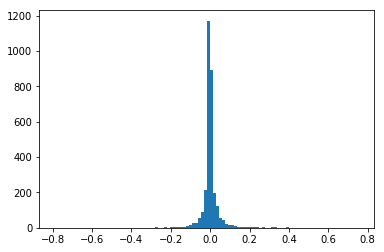

In [162]:
# Look at distribution of percent_gain feature
print('distribution mean',np.mean(trades['percent_gain']))
print('distribution std',np.std(trades['percent_gain']))
plt.hist(trades['percent_gain'].values,bins=100)
plt.plot()

In [163]:
# For fitting exp curves to data
def exp_line(x, a, b, c):
     return a * np.exp(-b * x) + c
def gauss(x, A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

## Split the dataset into two halves
#### Show stop distributions on winning side and losing side

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.31
 0.32 0.33 0.39 0.4  0.42 0.46 0.65 0.76] [361 285 145  86  73  37  35  27  18   9   9   8  11   7   3   4   5   4
   3   1   3   3   5   2   2   1   1   1   1   2   2   2   1   1   1   1]
[361 285 145  86  73  37  35  27  18   9   9   8  11   7   3   4   5   4
   3   1   3   3   5   2   2   1   1   1   1   2   2   2   1   1   1   1]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.31
 0.32 0.33 0.39 0.4  0.42 0.46 0.65 0.76]
popt [372.90960814  43.00418497   2.59006074] pcov [[67.13593802  6.50025245 -1.755029  ]
 [ 6.50025245  3.09239308  1.18644107]
 [-1.755029    1.18644107  3.02997307]]


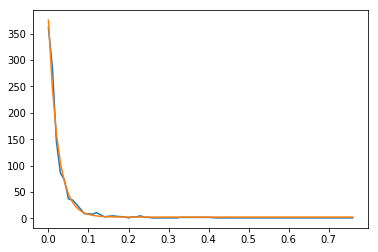

In [164]:
positive_mask = pd.to_numeric(trades['percent_gain'] > 0)
positive_values = trades['percent_gain'][positive_mask].round(2).values
x = sorted(positive_values)
pos_unique, pos_counts = return_uniques(positive_values)
# print(np.bincount(inverse))
print(pos_counts)
print(pos_unique)
plt.plot(pos_unique,pos_counts)
pos_popt, pos_pcov = curve_fit(exp_line,  pos_unique,  pos_counts) # p0=(4, 0.1)
    
print('popt',pos_popt,'pcov', pos_pcov)
plt.plot(pos_unique,exp_line(pos_unique,*pos_popt))

plt.show()

popt [837.84135137 -60.18175026   1.44492892] pcov [[565.62995471 -31.92915389 -15.71077013]
 [-31.92915389  11.17052203  -5.29800024]
 [-15.71077013  -5.29800024  22.44689839]]


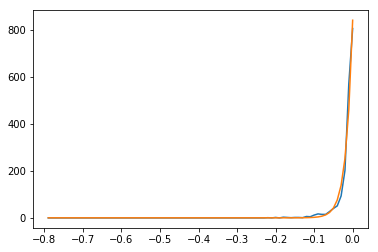

In [165]:
negative_mask = pd.to_numeric(trades['percent_gain'] <= 0)
negative_values = trades['percent_gain'][negative_mask].round(2).values
x = sorted(negative_values)
neg_unique, neg_counts = np.unique(negative_values, return_counts=True)
plt.plot(neg_unique,neg_counts)

popt, pcov = curve_fit(exp_line,  neg_unique,  neg_counts)
    
print('popt',popt,'pcov', pcov)
plt.plot(neg_unique,exp_line(neg_unique,*popt))
plt.show()

## Check percentages of the distribution. How often does a particular stop get triggered.

In [166]:
#Goal is to generate a graph where we can plot the likelyhood of a stop getting triggered based on where you put it.

neg_sum_counts = sum(neg_counts)
pos_sum_counts = sum(pos_counts)
total_sum_counts = neg_sum_counts + pos_sum_counts
print('neg,pos, and total sums',neg_sum_counts,pos_sum_counts,total_sum_counts)
negative_freqs = []
positive_freqs = {}
total_distribution_freqs = {}

total_counts = np.concatenate([neg_counts,pos_counts])
total_uniques = np.concatenate([neg_unique,pos_unique])
print('total_counts',total_counts)
print('total_uniques',total_uniques)

negative_freqs = [neg_counts[idx]/neg_sum_counts for idx in range(len(neg_unique))]
negative_freq_dict = {neg_unique[idx]:sum(negative_freqs[:idx]) for idx in range(len(neg_unique))}

positive_freqs = [pos_counts[idx]/pos_sum_counts for idx in range(len(pos_unique))]
positive_freq_dict = {pos_unique[idx]:sum(positive_freqs[:idx]) for idx in range(len(pos_unique))}

total_freqs = [total_counts[idx]/total_sum_counts for idx in range(len(total_uniques))]
total_distribution_sums_freqs = {total_uniques[idx]:sum(total_freqs[:idx]) for idx in range(len(total_uniques))}

total_distribution_freqs = {total_uniques[idx]:total_freqs[idx] for idx in range(len(total_uniques))}

neg,pos, and total sums 1902 1160 3062
total_counts [  1   1   1   1   1   1   1   1   1   1   1   2   1   3   1   4   3   2
   3   3   2   7   6  13  18  16  16  28  41  52  94 202 570 804 361 285
 145  86  73  37  35  27  18   9   9   8  11   7   3   4   5   4   3   1
   3   3   5   2   2   1   1   1   1   2   2   2   1   1   1   1]
total_uniques [-0.79 -0.48 -0.43 -0.4  -0.36 -0.33 -0.3  -0.28 -0.27 -0.26 -0.23 -0.22
 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1
 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 -0.    0.    0.01
  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13
  0.14  0.15  0.16  0.17  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26
  0.27  0.31  0.32  0.33  0.39  0.4   0.42  0.46  0.65  0.76]


## Graph of total trade distribution

(70,) (70,)


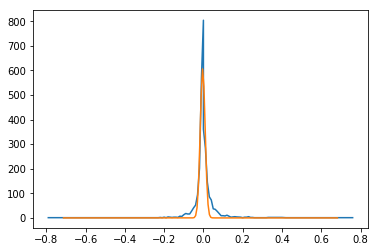

In [167]:
# Distribution is not normal
# Fit needs to be adjusted. Its really two seperate curves. as seen above
total_X = np.append(neg_unique,pos_unique)
total_Y = np.append(neg_counts,pos_counts)
print(total_X.shape,total_Y.shape)

total_values = sorted(negative_values) + sorted(positive_values)

p0 = [1., 0., 1.]
hist, bin_edges = np.histogram(total_values, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
new_bin_centers = np.linspace(bin_centres[0], bin_centres[-1], 200)
# coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
coeff, var_matrix = curve_fit(gauss, total_X, total_Y)
new_hist_fit = gauss(new_bin_centers, *coeff) 
# hist_fit = gauss(bin_centres, *coeff)
# plt.plot(bin_centres, hist, label='Test data')
# plt.plot(bin_centres, hist_fit, label='Fitted data')
plt.plot(total_X,total_Y)
plt.plot(new_bin_centers, new_hist_fit)
# plt.plot(total_X,exp_line(total_X,*coeff))
plt.show()
# mean,std = norm.fit(total_values)
# plt.hist(total_values, bins=100, density=True)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# y = norm.pdf(x, mean, std)
# plt.show()

In [168]:
# Dictionary of percentage gain/loss and percent of useful trades

# negative_freq_dict
# positive_freq_dict
# total_distribution_freqs
total_distribution_sums_freqs

{-0.79: 0,
 -0.48: 0.00032658393207054214,
 -0.43: 0.0006531678641410843,
 -0.4: 0.0009797517962116264,
 -0.36: 0.0013063357282821686,
 -0.33: 0.0016329196603527107,
 -0.3: 0.001959503592423253,
 -0.28: 0.0022860875244937948,
 -0.27: 0.002612671456564337,
 -0.26: 0.0029392553886348795,
 -0.23: 0.003265839320705422,
 -0.22: 0.003592423252775964,
 -0.21: 0.004245591116917049,
 -0.2: 0.004572175048987591,
 -0.19: 0.0055519268451992175,
 -0.18: 0.00587851077726976,
 -0.17: 0.007184846505551928,
 -0.16: 0.008164598301763555,
 -0.15: 0.00881776616590464,
 -0.14: 0.009797517962116267,
 -0.13: 0.010777269758327894,
 -0.12: 0.011430437622468979,
 -0.11: 0.013716525146962774,
 -0.1: 0.015676028739386026,
 -0.09: 0.019921619856303075,
 -0.08: 0.025800130633572834,
 -0.07: 0.03102547354670151,
 -0.06: 0.03625081645983018,
 -0.05: 0.04539516655780536,
 -0.04: 0.05878510777269759,
 -0.03: 0.07576747224036579,
 -0.02: 0.10646636185499675,
 -0.01: 0.17243631613324625,
 -0.0: 0.6211626387981711,
 0.01:

## Multiple trades in the same stock in a day

Checking to see if there is any correlation if he is making multiple trades in a stock.
The results indicate there are not. As the later number of trades are too infrequent.

In [169]:
beginning_day = parser.parse(useful_trades.opendt.values[0]).day
day_dictionary = {}
totals_dictionary = {}
print('first day',beginning_day)
for trade in range(useful_trades.shape[0]):
#     print('idx',trade)
    #check if day matches then accrue all trades that day of each stock
    current_day = parser.parse(useful_trades.opendt.values[trade]).day
#     print('days',current_day,beginning_day)
    if current_day != beginning_day:
#         print('new day')
        beginning_day = current_day
        #add day totals to totals_dictionary
        for stock in day_dictionary:
#             print(stock)
            for index,value in enumerate(day_dictionary[stock]):
                key = index+1
                if key in totals_dictionary:
                    totals_dictionary[key]['value'] += value
                    totals_dictionary[key]['count'] += 1
                else:
                    totals_dictionary[key] = { 'value':value,'count':1}
        #clear dictionary
        day_dictionary = {}
        ticker = useful_trades['symbol'].values[trade]
        gain = useful_trades['per_share_return'].values[trade]
        day_dictionary[ticker] = [gain]
#         print(totals_dictionary)
    else:
        ticker = useful_trades['symbol'].values[trade]
        gain = useful_trades['per_share_return'].values[trade]
#         print(ticker,gain)
        if ticker in day_dictionary:
            day_dictionary[ticker].append(gain)
        else:
            day_dictionary[ticker] = [gain]
        

first day 30


In [170]:
# Per share return based on how many trades in that stock in a given day
for key in totals_dictionary:
    totals_dictionary[key]['total'] = totals_dictionary[key]['value'] / totals_dictionary[key]['count']
totals_dictionary

{1: {'value': 182.49611528295566, 'count': 1331, 'total': 0.1371120325191252},
 2: {'value': 30.795290690091054, 'count': 292, 'total': 0.10546332428113375},
 3: {'value': 16.94135628076323, 'count': 112, 'total': 0.1512621096496717},
 4: {'value': -14.584009915322458, 'count': 58, 'total': -0.25144844681590445},
 5: {'value': 9.205135846793986, 'count': 35, 'total': 0.26300388133697106},
 6: {'value': -6.565234456657567, 'count': 18, 'total': -0.3647352475920871},
 7: {'value': -6.047751533328774, 'count': 13, 'total': -0.4652116564099057},
 8: {'value': -11.15327182340648, 'count': 8, 'total': -1.39415897792581},
 9: {'value': 0.7166199999999999, 'count': 2, 'total': 0.35830999999999996},
 10: {'value': 0.0003166666666666318,
  'count': 2,
  'total': 0.0001583333333333159},
 11: {'value': -0.175489, 'count': 2, 'total': -0.0877445},
 12: {'value': 0.39308, 'count': 2, 'total': 0.19654},
 13: {'value': -0.50213, 'count': 2, 'total': -0.251065},
 14: {'value': -0.51667, 'count': 2, 'to

### Plots of performance by Per_share_return

+ By Sector
+ By Industry
+ By Volatility (3 different ways of computing)

[69.61682002094926] 1020.2107986896972 [-56.980347336806354] [530.9913069202898] [493.25273146832444]


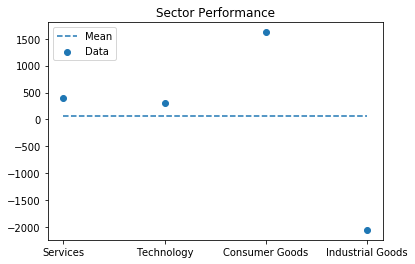

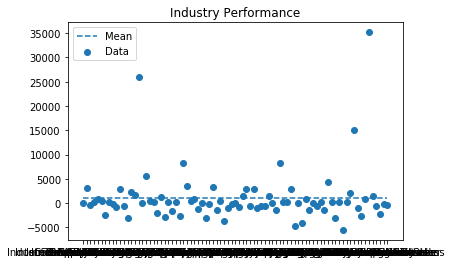

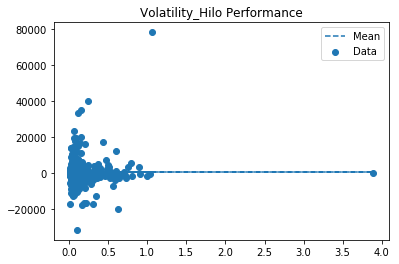

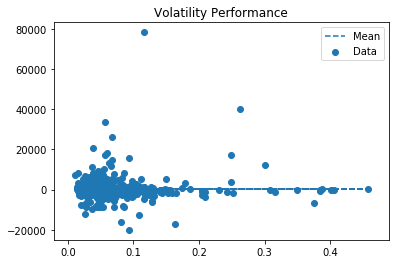

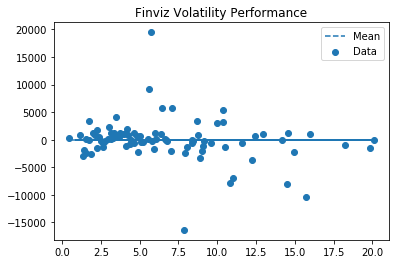

In [171]:
#
industry_mean = [np.mean(industry_y) for i in industry_y]
sector_mean = [[np.mean(sector_y)] for i in sector_y]
finviz_mean = [[np.mean(volatility_finviz_y)] for i in volatility_finviz_y]
volatility_mean = [[np.mean(volatility_y)] for i in volatility_y]
hilo_mean = [[np.mean(volatility_hilo_y)] for i in volatility_hilo_y]
print(sector_mean[0],industry_mean[0],finviz_mean[0],volatility_mean[0],hilo_mean[0])
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(sector_x,sector_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(sector_x,sector_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper left')
plt.title('Sector Performance')
plt.show()

fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(industry_x,industry_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(industry_x,industry_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper left')
plt.title('Industry Performance')

plt.show()
###
# Variance
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_hilo_x,volatility_hilo_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_hilo_x,hilo_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')
plt.title('Volatility_Hilo Performance')

plt.show()
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_x,volatility_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_x,volatility_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')
plt.title('Volatility Performance')

plt.show()
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_finviz_x,volatility_finviz_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_finviz_x,finviz_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')
plt.title('Finviz Volatility Performance')

plt.show()

Check the R values of the various volatility graphs

In [172]:
# mask = ~np.isnan(volatility_x) & ~np.isnan(volatility_y)
# mask_2 = ~np.isnan(volatility_hilo_x) & ~np.isnan(volatility_hilo_y)
# vol_index = np.where(mask==False)[0][0]
# vol2_index = np.where(mask_2==False)[0][0]
# print(vol_index)
# print(vol2_index)
# del volatility_x[vol_index]
# del volatility_y[vol_index]
# del volatility_hilo_x[vol2_index]
# del volatility_hilo_y[vol2_index]
print(linregress(volatility_finviz_x, volatility_finviz_y))
print(linregress(np.array(volatility_x), np.array(volatility_y)))
print(linregress(volatility_hilo_x, volatility_hilo_y))

LinregressResult(slope=-174.40245938517572, intercept=1115.7572812607377, rvalue=-0.20420501044566966, pvalue=0.05634155691363972, stderr=90.15458127278296)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)


# Ryan's Trading Data Summary


+ Time span : 490 days, 23:00:32
+ Number of trades : 3062
+ Average Number of trades per day : 11.39
+ Winning frequency: 37%
+ Losing frequency: 62%
+ Average win : 2547
+ Average loss : 1252
+ Average per trade return : 189
+ Longest trade : 214 days, 20:44:22
+ Shortest trade : 0 seconds

### Average return for useful trades by sector

() represents data with outliers

*Consumer Goods*
+ Average Return: 501 (790.2)
+ Trade instances: 270
+ Per share stats:
+ + Per share return: 0.18 (0.288)
+ + mean return 0.03858337869614742
+ + std 2.1049901853307573
+ + mad 1.2388000295034434
['LULU', 'FIZZ', 'TSLA', 'KODK', 'FTFT', 'GM', 'PBI', 'NHTC', 'AAPL', 'BG', 'MAT', 'HAS', 'IP', 'HOG', 'HLF', 'SAFM', 'RFP', 'GPRO', 'IRBT', 'BLL', 'COTY', 'EPC', 'GOOS', 'SPB', 'NWL', 'MPAA', 'ICON', 'UAA', 'FOSL', 'UA', 'SNBR', 'CPB', 'NAV', 'FNKO', 'VUZI', 'CALM', 'ETH', 'PM', 'MO', 'CLW', 'ELY', 'VSTO', 'FCAU', 'REV', 'LZB', 'FORD', 'BGS', 'TAP', 'SJM', 'SKX', 'PETZ', 'PLAG', 'BUD', 'SOLO', 'TPX', 'BTI', 'TVPT', 'VFC', 'KBSF', 'HRL', 'TIS', 'DECK', 'NIO', 'FARM']

*Services*
+ Average Return: 160 (252.4)
+ Trade instances: 437
+ Per share stats:
+ + Per share return: 0.073 (0.115)
+ + mean return 0.08367928260470203
+ + std 1.5101002800075556
+ + mad 0.9059593947765603
['KR', 'NFLX', 'TITN', 'BABA', 'CNET', 'NXTD', 'ROKU', 'WTW', 'LOW', 'PFMT', 'CBS', 'VIAB', 'HRB', 'MARA', 'TSG', 'WYNN', 'CASY', 'SFLY', 'HD', 'CATM', 'EBAY', 'BOOT', 'JWN', 'EXPE', 'ULTA', 'WBA', 'GNC', 'SCI', 'IPG', 'WEN', 'SHAK', 'UEPS', 'DPZ', 'VRSK', 'HUBG', 'QUAD', 'CBRL', 'CAKE', 'CAR', 'HTZ', 'STN', 'CHTR', 'WBAI', 'ZAGG', 'COST', 'DESP', 'HGV', 'TLYS', 'SPEX', 'SIG', 'TLRD', 'HUD', 'CTRP', 'BKS', 'BKE', 'KTOS', 'FDX', 'FIVE', 'DXPE', 'OMEX', 'DSS', 'BGI', 'ONE', 'GME', 'RH', 'OLLI', 'SPOT', 'HLG', 'BBBY', 'MCD', 'MGM', 'PIR', 'SSTK', 'IMTE', 'BLNK', 'LBTYA', 'CZR', 'SGMS', 'PENN', 'BYD', 'IGT', 'HTHT', 'KSS', 'AMCX', 'OMC', 'GPS', 'LABL', 'CARS', 'LYV', 'GES', 'SPTN', 'JILL', 'EXPR', 'KIRK', 'BIG', 'DDE', 'ANF', 'HUYA', 'MTN', 'SFIX', 'CONN', 'ETSY', 'DIS', 'NEW', 'SBUX', 'PZZA', 'WMT', 'DNKN', 'DISH', 'TRCO', 'EEFT', 'ORLY', 'YUMC', 'CMG', 'GPX', 'LL', 'ROST', 'YVR', 'WWE', 'MMYT', 'FISV', 'GOLF', 'SEAS', 'CMCSA', 'GCI', 'TIVO', 'XPO', 'TPNL', 'HYRE', 'RBZ']

*Technology*
+ Average Return: 178 (170.9)
+ Trade instances: 845
+ Per share stats:
+ + Per share return: 0.061 (0.058)
+ + mean return 0.15962169178506477
+ + std 2.0493161134458213
+ + mad 1.0714548347585782
['FB', 'NTNX', 'NVDA', 'PANW', 'HUBS', 'FSLR', 'SQ', 'FNSR', 'DPW', 'XNET', 'QD', 'GOOG', 'EA', 'NETE', 'STX', 'FRSX', 'AKAM', 'NUAN', 'CCIH', 'HMNY', 'CDK', 'BIDU', 'INPX', 'QCOM', 'AVGO', 'LIVE', 'ADSK', 'PTC', 'TXN', 'RMBS', 'IBM', 'FEYE', 'LRCX', 'SPWR', 'IDT', 'SSTI', 'WDC', 'INTC', 'OLED', 'VMW', 'MXIM', 'WB', 'ANET', 'SHOP', 'TTD', 'AMD', 'SINA', 'PLT', 'CTXS', 'MKSI', 'NCTY', 'NOW', 'LITE', 'SNAP', 'MCHP', 'DGLY', 'MSFT', 'CRUS', 'MARK', 'YELP', 'GRUB', 'IAC', 'BR', 'UIS', 'RNG', 'TWLO', 'EIGI', 'CARB', 'TRUE', 'TRIP', 'PI', 'SEDG', 'SNCR', 'ANY', 'AAOI', 'TWTR', 'STMP', 'BAND', 'MOMO', 'HPE', 'MU', 'DATA', 'RUN', 'ACMR', 'SOHU', 'HPQ', 'OKTA', 'JD', 'AMAT', 'COUP', 'SILC', 'WIX', 'DDD', 'RUBI', 'ADBE', 'CSIQ', 'ZS', 'SGH', 'RHT', 'IDTI', 'HEAR', 'QNST', 'NXPI', 'ACIA', 'YNDX', 'DCAR', 'IZEA', 'LLNW', 'UCTT', 'MTCH', 'HCHC', 'SYNA', 'GRPN', 'I', 'SYMC', 'DBX', 'IQ', 'MIME', 'SWCH', 'ADP', 'ALTR', 'BOXL', 'TTWO', 'NTES', 'PLAB', 'BILI', 'CRM', 'DOCU', 'ZUO', 'TEAM', 'AMBA', 'CLDR', 'YY', 'VRNT', 'OCC', 'RFIL', 'NNDM', 'PVTL', 'BITA', 'JBL', 'JT', 'CLPS', 'PS', 'SATS', 'SMAR', 'AVLR', 'ABIL', 'AWSM', 'CNTF', 'CSCO', 'XRX', 'UBNT', 'CPAH', 'SWKS', 'TER', 'CVLT', 'NLSN', 'SCON', 'QLYS', 'AYI', 'CDNS', 'JNPR', 'COMM', 'DXC', 'ARRS', 'XLNX', 'PFPT', 'APH', 'VRNS', 'FIT', 'MAXR', 'GRVY', 'SSYS', 'VECO', 'VRSN', 'RP', 'Z', 'UPWK', 'MLNX', 'ANSS', 'ATVI', 'TCX', 'INTU', 'MTLS', 'FFIV', 'NPTN', 'SLAB', 'ZAYO', 'EGAN', 'RAMP', 'SVMK']

*Industrial Goods*
+ *Average Return:* 370 (-765.2)
+ *Trade instances:* 18
+ Per share stats:
+ + *Per share return:* 0.074 (-0.163)
+ + mean return 1.1544136445944986
+ + std 3.4246974526980067
+ + mad 2.404736971843354
['OSIS', 'GE', 'BLDP', 'GGG', 'SITE', 'DHR', 'EMR', 'SEII', 'ZBRA', 'WY', 'ROP', 'TBLTU']

### Average return for useful trades by industry

sorted by per share return

*Auto Manufacturers - Major*
+ number of trades 119
+ total result 109908
+ per share 0.3931126244706421
+ mean return 0.03320715378030502
+ std 2.889791432144063
+ mad 1.9117028604442343
['TSLA', 'GM', 'FCAU', 'SOLO', 'NIO']

*Business Software & Services*
+ number of trades 27
+ total result 15736
+ per share 0.34242193450114244
+ mean return 0.05597747959070302
+ std 0.9856471713844153
+ mad 0.7172340799527638
['CTXS', 'MSFT', 'CARB', 'BAND', 'ADP', 'DOCU', 'VRNT', 'SMAR', 'FFIV', 'EGAN']

*CATV Systems*
+ number of trades 89
+ total result 33386
+ per share 0.223070035946708
+ mean return 0.07540924227698935
+ std 2.214225433248382
+ mad 1.39499546635727
['NFLX', 'ROKU', 'CHTR', 'IMTE', 'LBTYA', 'DISH', 'TIVO']

*Communication Equipment*
+ number of trades 45
+ total result 13728
+ per share 0.19597710174306557
+ mean return 0.36237964641478426
+ std 1.1150981850912185
+ mad 0.8288008616516234
['FNSR', 'QCOM', 'PLT', 'LITE', 'PI', 'HPE', 'SILC', 'HEAR', 'ACIA', 'BOXL', 'OCC', 'SATS', 'ABIL', 'AWSM', 'CNTF', 'CSCO', 'UBNT', 'JNPR', 'COMM', 'ARRS', 'MAXR', 'ZAYO']

*Semiconductor - Specialized*
+ number of trades 96
+ total result 26588
+ per share 0.16209131200809604
+ mean return 0.2400352059651284
+ std 2.1458710437510775
+ mad 1.4185579515163351
['NVDA', 'FSLR', 'SPWR', 'CRUS', 'SEDG', 'RUN', 'CSIQ', 'ALTR']

*Semiconductor - Broad Line*
+ number of trades 49
+ total result 38730
+ per share 0.12642608823385398
+ mean return 0.14610398818453826
+ std 0.7118521574061379
+ mad 0.5251304072503105
['AVGO', 'TXN', 'INTC', 'MXIM', 'AMD', 'MCHP', 'IDTI', 'NXPI', 'MLNX', 'NPTN']

*Application Software*
+ number of trades 133
+ total result 47600
+ per share 0.10892797480926163
+ mean return 0.2945271000791092
+ std 3.192741239999751
+ mad 1.4276287125249927
['HUBS', 'XNET', 'NUAN', 'CDK', 'INPX', 'FEYE', 'SSTI', 'SHOP', 'TTD', 'RNG', 'TWLO', 'EIGI', 'SNCR', 'ANY', 'STMP', 'DATA', 'RUBI', 'ADBE', 'RHT', 'DCAR', 'SYNA', 'DBX', 'MIME', 'CRM', 'ZUO', 'CLDR', 'PVTL', 'PS', 'AVLR', 'CPAH', 'CVLT', 'QLYS', 'CDNS', 'PFPT', 'RP', 'ANSS', 'INTU', 'MTLS', 'SVMK']

*Semiconductor- Memory Chips*
+ number of trades 39
+ total result 11807
+ per share 0.07136294953158054
+ mean return -0.008554921178341285
+ std 0.7210118044976411
+ mad 0.42039955623661013
['RMBS', 'MU', 'SGH']

*Information Technology Services*
+ number of trades 40
+ total result 5731
+ per share 0.05812609030792324
+ mean return 0.404451499330416
+ std 1.0244399179267887
+ mad 0.8230586311935392
['QD', 'HMNY', 'IBM', 'NOW', 'UIS', 'SWCH', 'TEAM', 'JT', 'CLPS', 'XRX', 'DXC', 'RAMP']

*Internet Information Providers*
+ number of trades 214
+ total result 22565
+ per share 0.045618482712889624
+ mean return 0.05777967980234797
+ std 2.3975689976310566
+ mad 1.3001269335177859
['FB', 'GOOG', 'AKAM', 'CCIH', 'BIDU', 'LIVE', 'WB', 'MARK', 'YELP', 'GRUB', 'IAC', 'TRIP', 'TWTR', 'SOHU', 'JD', 'WIX', 'YNDX', 'LLNW', 'MTCH', 'GRPN', 'IQ', 'BILI', 'YY', 'BITA', 'VRSN', 'Z', 'UPWK', 'TCX']

*Specialty Retail, Other*
+ number of trades 77
+ total result -1304
+ per share -0.007991959010566057
+ mean return -0.13078200048756441
+ std 0.861532686864699
+ mad 0.5626837218011679
['BABA', 'EBAY', 'ULTA', 'ZAGG', 'HUD', 'BKS', 'FIVE', 'PIR', 'SFIX', 'ETSY', 'RBZ']

*Internet Software & Services*
+ number of trades 68
+ total result -6263
+ per share -0.02059851801178092
+ mean return 0.051877717597090416
+ std 0.7329697539398508
+ mad 0.5273064575194221
['SQ', 'NETE', 'SINA', 'SNAP', 'MOMO', 'COUP', 'QNST', 'NTES']

*Electronic Equipment*
+ number of trades 41
+ total result -4981
+ per share -0.03028423772609819
+ mean return 0.0713641614784678
+ std 0.6235055154101247
+ mad 0.4925298304319038
['KODK', 'AAPL', 'VUZI']

*Technical & System Software*
+ number of trades 36
+ total result -23450
+ per share -0.24913413934513312
+ mean return -0.10941156953210793
+ std 1.1480634365740785
+ mad 0.80760433784565
['NTNX', 'ADSK', 'PTC', 'VMW', 'OKTA', 'VRNS']

*Entertainment - Diversified*
+ number of trades 48
+ total result -35465
+ per share -0.3211420395892569
+ mean return -0.2990172670921069
+ std 0.6050038461053822
+ mad 0.4139559753667947
['CBS', 'VIAB', 'AMCX', 'LYV', 'HUYA', 'DIS', 'YVR', 'WWE', 'CMCSA']

*Semiconductor Equipment & Materials*
+ number of trades 29
+ total result -16890
+ per share -0.3231237206098984
+ mean return -0.30574404657549137
+ std 1.6324115773991716
+ mad 1.0725667533803294
['LRCX', 'OLED', 'ACMR', 'AMAT', 'UCTT', 'PLAB', 'AMBA', 'TER', 'SCON', 'VECO']

### Average return for all trades by sector

*Consumer Goods*
+ Average Return: 808.9413919413919
+ Trade instances: 273

*Basic Materials*
+ Average Return: 770.8888888888889
+ Trade instances: 72

*Services*
+ Average Return: 303.9076923076923
+ Trade instances: 585

*Financial*
+ Average Return: 297.11042944785277
+ Trade instances: 163

*Technology*
+ Average Return: 156.5719298245614
+ Trade instances: 855

*Industrial Goods*
+ Average Return: -156.7941176470588
+ Trade instances: 68

*Healthcare*
+ Average Return: -219.67857142857142
+ Trade instances: 364

*Utilities*
+ Average Return: -1596.8148148148148
+ Trade instances: 27


## Charts

ticker variance compared to profitability


## Durations

##### For All Trades
| Time | Percentage of trades   |
|------|------|
|   2hr <  | 0.689|
|   1hr <  | 0.614|
|   30mins <  | 0.526|
|   15mins <  | 0.453|
|   7.5mins <  | 0.367|
|   3.75mins <  | 0.287|
|   1min <  | 0.139|

##### For 'Useful' Trades
| Time | Percentage of trades   |
|------|------|
|   2hr <  | 0.70|
|   1hr <  | 0.62|
|   30mins <  | 0.53|
|   15mins <  | 0.47|
|   7.5mins <  | 0.38|
|   3.75mins <  | 0.29|
|   1min <  | 0.14|


# Stats on Useful trading data
Selection Process
---
+ minimum loss: 0.02%
+ minimum gain: 0.08
+ minimum trade duration: 2 hours
---
+ Number of trades: 553
+ Positive trades: 274 
+ Negative trades: 278 
+ breakeven: 1
+ win%: 0.495
+ loss% 0.50
+ tie%: 0.0018
+ per share gain: 0.177
+ 712.98
+ total amount lost: -671589
+ average loss: -2415.78
+ total amount won: 1065870
+ average loss 3890
+ Win/Loss: 1.587
+ total shares traded: 2220121.66
+ total realized: 394281
+ max loss: -31585
+ max win: 78356
+ max loss percent: -0.358
+ max gain percent: 0.312


### Workflow

Ideally when Ryan is trading, he can utilize software to improve his trading accuracy and profit. 
This would involve any of the following real time projections:
* Stock variance. 
* Likelyhood of a winning trade based on available metrics. 
* Win if right, loss if wrong.

The action sequence would look something like this.
Stock ticker -> Variance -> Trade Type -> winning percent -> win/loss -> kelly criterion -> decision


### XGBoost

Goals:
* Predict stops and gains for wins/losses.
* Predict volatility.

By training two models, one only on wins, the other on losses. And then running them on each other's data to add projected losses for his wins and wins for his losses. 

The reason behind this, is that everytime he has made a winning trade. He had some stop loss. But there is too much data (and too little will) to retroactively try and manually input those stops. It can be difficult to know where it would have been based on the conditions at hand. 

Additionally, see how well we can project a volatility metric, and if so what features are most important in doing so?

**Predict Finviz "Monthly Volatility":**

Ryan suggested the following, but initially we will use as many as we can:

+ Dividend yield
+ Operating margin
+ Profit margin
+ Short interest %
+ Institutional own %
+ Market Cap
+ Debt/equity %

In [173]:
# initialize helper tools
enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
scaler = StandardScaler()

In [174]:
# XGBoost and data splitting functions 

def return_model(params):
    num_round,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,objective,scale_pos_weight,seed = params.values()
    model = XGBRegressor(num_round = num_round,
    learning_rate = learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    objective=objective,
    scale_pos_weight=scale_pos_weight,
    seed=seed)
    return model

# Target Column is not part of cat or num columns
def scale_data(data,categorical_columns,numerical_columns,target_column,fill_mean=False):
    if data[target_column].isnull().values.any() == True:
        #create mask and drop those rows
        print('missing y values',data[target_column].isnull().sum())
        missing_mask = data[target_column].notnull()
        dataset = data[missing_mask]
    else:
        print('no missing y values')
        dataset = copy.copy(data)
    categorical_slice = dataset[categorical_columns].apply(le.fit_transform)
    numerical_slice = dataset[numerical_columns]
    if fill_mean == True:
        numerical_slice.fillna(numerical_slice.mean(), inplace=True)
    scaler.fit_transform(numerical_slice)
    numerical_slice = numerical_slice.round(2)
    # This reindexing is necessary to avoid pandas adding extra rows
    numerical_slice.reset_index(drop=True, inplace=True)
    categorical_slice.reset_index(drop=True, inplace=True)
    scaled_data = pd.concat([numerical_slice,categorical_slice,data[target_column]],axis=1)
    return scaled_data
    

def return_data(data,categorical_columns,numerical_columns,target_column,fill_mean=False):
    #Check if there are NAN values in the target_column. If so, drop those rows from the dataset
    if data[target_column].isnull().values.any() == True:
        #create mask and drop those rows
        print('missing y values',data[target_column].isnull().sum())
        missing_mask = data[target_column].notnull()
        dataset = data[missing_mask]
    else:
        dataset = copy.copy(data)
    categorical_slice = dataset[categorical_columns].apply(le.fit_transform)
    numerical_slice = dataset[numerical_columns]
    if fill_mean == True:
        numerical_slice.fillna(numerical_slice.mean(), inplace=True)
    scaler.fit_transform(numerical_slice)
    numerical_slice = numerical_slice.round(2)
    # This reindexing is necessary to avoid pandas adding extra rows
    numerical_slice.reset_index(drop=True, inplace=True)
    categorical_slice.reset_index(drop=True, inplace=True)
    scaled_data = pd.concat([numerical_slice,categorical_slice],axis=1)
#     X = scaled_data.drop(scaled_data[[target_column]],axis=1).values
    X = scaled_data.values
    y = dataset[target_column].values
    print('X',X.shape)
    print('y',y.shape)
    assert X.shape[0] == y.shape[0]
    return split_data(X,y)

def split_data(X,y):
    # Vars for splitting data
    seed = 7
    test_size = 0.25
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train, X_valid, y_train, y_valid
    
def return_accuracy(model,X_valid,y_valid):
    y_pred = model.predict(X_valid)
    print('predictions',y_pred[:5])
    distance = np.subtract(y_valid,y_pred)
    #remove Nans
    distance = distance[~np.isnan(distance)]
    print('mean and std of distance',np.mean(distance),np.std(distance))
    print('distance',distance[:5])
    print('targets',y_valid[:5])
    accuracy = np.sum(distance) / distance.shape[0]
    print("Average distance:" , accuracy)
    
def XGBoostTrain(X_train, X_valid, y_train, y_valid,model):
#     param = {'verbosity':1, 'objective':'reg:gamma', 'booster':'gbtree', 'base_score':3}
#     watchlist = [(X_valid, 'eval'), (X_train, 'train')]
#     dtrain = xgb.DMatrix( X_train, label=y_train ) 
#     dvalid = xgb.DMatrix( X_valid, label=y_valid ) 
#     eval_set = [(dtrain, 'train'), (dvalid,'valid')]
    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    eval_metric = ["rmse"]
#     model = xgb.train(params.items(),dtrain,eval_set)
    model.fit(X_train, y_train,eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    print(model)
    return_accuracy(model,X_valid,y_valid)
    return model

def XGBoostTrainOnly(X_train, y_train,model):
    model.fit(X_train, y_train)
    return model

# Cross Validation Search
def CVSearch(X_train, y_train, params):
    dtrain = xgb.DMatrix( data=X_train, label=y_train ) 
#     dvalid = xgb.DMatrix( X_valid, label=y_valid ) 
    cv_results = xgb.cv(params=params,dtrain=dtrain, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
    print('best test cv result',cv_results["test-rmse-mean"].tail(1))
    return xgb.train(params=params, dtrain=dtrain, num_boost_round=10)

def plot_xgb_tree(model):
    # Plotting the tree, requires graphviz
    model.plot_tree(xg_reg,num_trees=0)
    plt.rcParams['figure.figsize'] = [50, 10]
    plt.show()

def CVGridSearch():
    pass

def do_train(X_train, X_valid, y_train, y_valid, initial_eta, min_eta, verbose=False):
    np.random.seed( 1 )
    random.seed(    1 )
    cv_scores    = []
    train_scores = []
#     split = StratifiedKFold(Y, 5, shuffle=True )
#     split = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
#     cv=skf.split(X_train,y_train)
    fold = 0
    
#     for train_index, cv_index in split:
    fold = fold + 1
    y_pred              = []

#         X_train, X_valid    = X[train_index,:], X[cv_index,:]
#         y_train, y_valid    = Y[train_index],   Y[cv_index]

    params = {
            "max_depth"             : 5, 
            "eta"                   : initial_eta,
            "min_eta"               : min_eta,
            "eta_decay"             : 0.5,
            "max_fails"             : 3,
            "early_stopping_rounds" : 20,
            "objective"             : 'reg:linear',
            "subsample"             : 0.8, 
            "colsample_bytree"      : 1.0,
            "n_jobs"                : -1,
            "n_estimators"          : 1000, 
            "silent"                : 1
    }

    num_round       = params["n_estimators"]
    eta             = params["eta"]
    min_eta         = params["min_eta"]
    eta_decay       = params["eta_decay"]
    early_stop      = params["early_stopping_rounds"]
    max_fails       = params["max_fails"]

    params_copy     = dict(params)

    dtrain          = xgb.DMatrix( X_train, label=y_train ) 
    dvalid          = xgb.DMatrix( X_valid, label=y_valid )  

    total_rounds        = 0
    best_rounds         = 0
    pvalid              = None
    model               = None
    best_train_score    = None
    best_cv_score       = None
    fail_count          = 0
    best_rounds         = 0
    best_model          = None

    while eta >= min_eta:           

        model        = xgb.train( params_copy.items(), 
                                  dtrain, 
                                  num_round, 
                                  [(dtrain, 'train'), (dvalid,'valid')], 
                                  early_stopping_rounds=early_stop,
                                  feval=evalauc )

        rounds          = model.best_iteration + 1
        total_rounds   += rounds

        train_score = mean_squared_error( y_train, model.predict(dtrain, ntree_limit=rounds) )
        cv_score    = mean_squared_error( y_valid, model.predict(dvalid, ntree_limit=rounds) )

        if best_cv_score is None or cv_score > best_cv_score:
            fail_count = 0
            best_train_score = train_score
            best_cv_score    = cv_score
            best_rounds      = rounds
            best_model       = model

            ptrain           = best_model.predict(dtrain, ntree_limit=rounds, output_margin=True)
            pvalid           = best_model.predict(dvalid, ntree_limit=rounds, output_margin=True)

            dtrain.set_base_margin(ptrain)
            dvalid.set_base_margin(pvalid)
        else:
            fail_count += 1

            if fail_count >= max_fails:
                break

        eta                 = eta_decay * eta
        params_copy["eta"]  = eta
    
    train_scores.append(best_train_score)
    cv_scores.append(best_cv_score)

    print("Fold [%2d] %9.6f : %9.6f" % ( fold, best_train_score, best_cv_score ))
        
    print("-------------------------------")
    print("Mean      %9.6f : %9.6f" % ( np.mean(train_scores), np.mean(cv_scores) ) )
    print("Stds      %9.6f : %9.6f" % ( np.std(train_scores),  np.std(cv_scores) ) )
    print("-------------------------------")
    return model
        
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

def display_features(model,data,is_booster=False):
    #Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
    if is_booster == True:  
        gain_importance = model.get_score(importance_type = 'gain')
        cover_importance = model.get_score(importance_type = 'cover')
        weight_importance = model.get_score(importance_type = 'weight')
        total_importance = model.get_score(importance_type = 'total_gain')
    else:
        gain_importance = model.get_booster().get_score(importance_type = 'gain')
        cover_importance = model.get_booster().get_score(importance_type = 'cover')
        weight_importance = model.get_booster().get_score(importance_type = 'weight')
        total_importance = model.get_booster().get_score(importance_type = 'total_gain')
    # Sort according to value
    sorted_gain = sorted(gain_importance.items(), key=operator.itemgetter(1))
    sorted_total = sorted(total_importance.items(), key=operator.itemgetter(1))
    sorted_weight = sorted(weight_importance.items(), key=operator.itemgetter(1))
    sorted_cover = sorted(cover_importance.items(), key=operator.itemgetter(1))
    # 
    feature_gain = [int(feature[0].strip('f')) for feature in sorted_gain]
    feature_weight = [int(feature[0].strip('f')) for feature in sorted_weight]
    feature_total = [int(feature[0].strip('f')) for feature in sorted_total]
    feature_cover = [int(feature[0].strip('f')) for feature in sorted_cover]
#     print('gain features',feature_gain)
#     print('weights features',feature_weight)
#     print('total features',feature_total)
#     print('cover features',feature_cover)
    #display column names
    print('gain column order',data.columns[feature_gain])
    print('weights column order',data.columns[feature_weight])
    print('total column order',data.columns[feature_total])
    print('cover column order',data.columns[feature_cover])
    
def evalauc(preds, dtrain):
    
    labels = dtrain.get_label()
    
    return 'mse', mean_squared_error(labels, preds)    
 
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [175]:
finviz.columns

Index(['No.', 'Ticker', 'Company', 'Sector', 'Industry', 'Country',
       'Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash',
       'P/Free Cash Flow', 'Dividend Yield', 'EPS growth next year',
       'EPS growth past 5 years', 'EPS growth next 5 years',
       'Sales growth past 5 years', 'EPS growth quarter over quarter',
       'Sales growth quarter over quarter', 'Shares Outstanding',
       'Shares Float', 'Institutional Ownership', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'LT Debt/Equity', 'Total Debt/Equity', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Beta', 'Average True Range',
       'Volatility (Week)', 'Volatility (Month)', '52-Week High',
       '52-Week Low', 'Average Volume', 'Relative Volume', 'Price', 'Change',
       'Volume', 'Earnings Date', 'Country.1', 'EarningsDate', 'Sector.1',
       'Industry.1', 'use?'],
      dtype='object')

## XGBoost on finviz data predicting volatility

In [176]:
# Just to see what we might be able to tease out with some basic stock metrics.
# Finviz only has one column per stock. But some of the metrics are over time.

print(finviz.shape)
finviz_categorical_columns = ['Sector', 'Industry', 'Country']
finviz_numerical_columns = ['Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash',
       'P/Free Cash Flow', 'Dividend Yield', 'EPS growth next year','EPS growth past 5 years', 'EPS growth next 5 years',
       'Sales growth past 5 years', 'EPS growth quarter over quarter',
       'Sales growth quarter over quarter', 'Shares Outstanding',
       'Shares Float', 'Institutional Ownership', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'LT Debt/Equity', 'Total Debt/Equity', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Beta', 'Average True Range',
       '52-Week High', '52-Week Low', 'Average Volume',
       'Relative Volume', 'Price', 'Change', 'Volume']

finviz_restricted_columns = ['Dividend Yield','Institutional Ownership','Operating Margin','Profit Margin',
                            'LT Debt/Equity', 'Total Debt/Equity','Float Short', 'Short Ratio','Market Cap',
                             'Average True Range'
                            ]
finviz_target_column = 'Volatility (Month)'
fill_mean = True

params = {'num_round': 30,
     'learning_rate' :0.01,
     'n_estimators':1000,
     'max_depth':5,
     'min_child_weight':1,
     'gamma':0,
     'subsample':0.8,
     'colsample_bytree':0.8,
     'objective':'reg:linear',
     'scale_pos_weight':1,
     'seed':27}

finviz_model = return_model(params)

kfold_params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

initial_eta = 0.1
min_eta = 0.0001


# scaled_data = scale_data(finviz,finviz_categorical_columns,finviz_numerical_columns,finviz_target_column,fill_mean)
# X = scaled_data.drop(scaled_data[[finviz_target_column]],axis=1).values
# Y = scaled_data[finviz_target_column].values

X_train, X_valid, y_train, y_valid = return_data(finviz,finviz_categorical_columns,
                                               finviz_restricted_columns,finviz_target_column,fill_mean)

# vol_model = do_train(X_train, X_valid, y_train, y_valid, initial_eta, min_eta, verbose=False)
sliced_finviz = finviz[finviz_restricted_columns+finviz_categorical_columns]
# finviz_cv = CVSearch(X_train, y_train, kfold_params)
finviz_model = XGBoostTrain(X_train, X_valid, y_train, y_valid,finviz_model)
# my_plot_importance(finviz_cv,(16,16))
# display_features(finviz_cv,sliced_finviz,True)

#Compare the two models
# preds = finviz_model.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# print("RMSE: %f" % (rmse))
# preds = finviz_cv.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# print("RMSE: %f" % (rmse))
# print(X_train.shape)
# print(X_valid.shape)
# print(y_train.shape)
# print(y_valid.shape)
# print(X_train[:10])
# print(y_train[:10])
# print(X_valid[:10])
# print(y_valid[:10])

# finviz_model = XGBoostTrainOnly(X_train, y_train, finviz_model)

# clf = GridSearchCV(model,
#                    {'max_depth': [2,4,6],
#                     'n_estimators': [50,100,200]}, verbose=1)
# clf.fit(X_train,y_train)
# print(clf.best_score_)
# print(clf.best_params_)
# model.fit(X_train,y_train)
# # Random Forest
# regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
# regressor.fit(X_train, y_train)  
# y_pred = regressor.predict(X_valid)  
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))  

(7592, 51)
missing y values 35


/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


X (7557, 13)
y (7557,)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_round=30, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
predictions [2.956649  2.82143   1.1863551 5.073872  2.2548175]
mean and std of distance 0.012351932555279407 1.4121777296557998
distance [ 0.79335093  0.05857003 -0.77635511  6.32612791 -0.84481749]
targets [ 3.75  2.88  0.41 11.4   1.41]
Average distance: 0.012351932555279407


In [177]:
y_pred = finviz_model.predict(X_valid)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred))  

Mean Absolute Error: 0.8134986014549064


## Display importance features for volatility

gain column order Index(['Total Debt/Equity', 'Industry', 'LT Debt/Equity', 'Operating Margin',
       'Institutional Ownership', 'Short Ratio', 'Average True Range',
       'Profit Margin', 'Country', 'Float Short', 'Dividend Yield',
       'Market Cap', 'Sector'],
      dtype='object')
weights column order Index(['Country', 'Total Debt/Equity', 'Sector', 'LT Debt/Equity', 'Industry',
       'Dividend Yield', 'Operating Margin', 'Profit Margin',
       'Average True Range', 'Short Ratio', 'Float Short',
       'Institutional Ownership', 'Market Cap'],
      dtype='object')
total column order Index(['Total Debt/Equity', 'Country', 'LT Debt/Equity', 'Industry',
       'Operating Margin', 'Profit Margin', 'Short Ratio', 'Dividend Yield',
       'Institutional Ownership', 'Average True Range', 'Float Short',
       'Sector', 'Market Cap'],
      dtype='object')
cover column order Index(['Total Debt/Equity', 'Industry', 'LT Debt/Equity', 'Short Ratio',
       'Institutional Ownership', 'Op

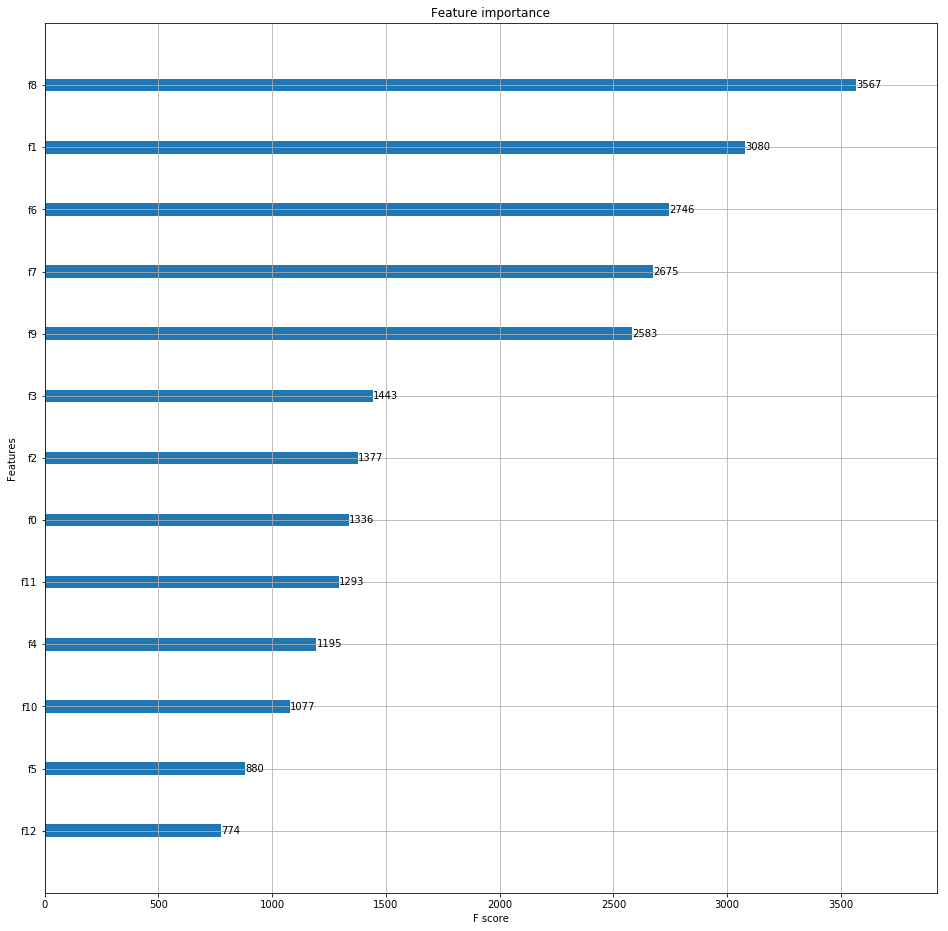

In [178]:
my_plot_importance(finviz_model,(16,16))
display_features(finviz_model,sliced_finviz,False)


In [179]:
sliced_finviz.columns[7]

'Short Ratio'

## Grid search XGBoost

In [180]:
# Grid search
# grid_search_params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

# grid_model = XGBRegressor(learning_rate=0.02, n_estimators=600, objective='reg:linear',
#                     silent=True, nthread=1)
# folds = 2
# param_comb = 2
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


# xgb_grid = GridSearchCV(grid_model,
#                         grid_search_params,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

# random_search = RandomizedSearchCV(grid_model, param_distributions=grid_search_params, 
#                                    n_iter=param_comb, scoring='roc_auc', 
#                                    n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# start_time = timer(None) # timing starts from this point for "start_time" variable
# xgb_grid.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


# y_test = random_search.predict_proba(test)
# results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
# results_df.to_csv('submission-random-grid-search-xgb-porto-01.csv', index=False)

# Grid search
# grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3 )
# grid.fit(X, Y)
# print('\n All results:')
# print(grid.cv_results_)
# print('\n Best estimator:')
# print(grid.best_estimator_)
# print('\n Best score:')
# print(grid.best_score_ * 2 - 1)
# print('\n Best parameters:')
# print(grid.best_params_)
# results = pd.DataFrame(grid.cv_results_)
# results.to_csv('xgb-grid-search-results-01.csv', index=False)

# y_test = grid.best_estimator_.predict_proba(test)
# results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
# results_df.to_csv('submission-grid-search-xgb-porto-01.csv', index=False)

In [181]:
list(trades.columns)

['idsym',
 'opendt',
 'symbol',
 'quantity',
 'is_long',
 'closedt',
 'realized',
 'open_fill_id',
 'close_fill_id',
 'average_entry_price',
 'average_exit_price',
 'firstEntPrice',
 'firstEntSize',
 'entVenue',
 'entLiqFlag',
 'entContra',
 'entAddTake',
 'lastExPrice',
 'lastExSize',
 'exVenue',
 'exLiqFlag',
 'exContra',
 'exAddTake',
 'earn_season',
 'earntrade',
 'posttrade',
 'ovntrade',
 'ipo_trade_day',
 'cb_day',
 'cb_flag',
 'halt_reopen_elapse',
 'halt_flag',
 'high',
 'low',
 'open',
 'close',
 'volume',
 'atr14',
 'vol5',
 'sma10',
 'sma50',
 'hi52w',
 'lo52w',
 'sma200',
 'vol30',
 'hi30d',
 'lo30d',
 'mktcap',
 'float',
 'pr_close',
 'hi52w_lag',
 'lo52w_lag',
 'ovn_chg',
 'vol30_lag',
 'vol5_lag',
 'vol_lag',
 'atr14_lag',
 'mvol',
 'mvol_chg',
 'mvol_chg_lag',
 'mvol_ptile50',
 'mvol_ptile50_lag',
 'mvol_ptile200',
 'mvol_ptile200_lag',
 'spy_op',
 'vix_op',
 'spy_cl',
 'spy_adj_cl',
 'vix_cl',
 'vxv_cl',
 'vxst_cl',
 'vvix_cl',
 'skew_cl',
 'idxpc_cl',
 'vixpc_cl',
 '

## XGBoost to predict gain/loss

In [182]:
useful_numerical_columns = ['voljump30','average_entry_price',
               'atr14','float','mktcap','spy_op','acv_crazy','vixpc_cl',
               'vix_op','ycv_per','acv_per','trade_volume','volume','prclose_chg',
                'avg_up','avg_dn','spy200_lag','spy50_lag','spy10_lag','spy200','spy50',
                'spy10','vix_ovn','vvix_ret','vix_ret','spy_cl','atr14_lag','acv_atr','ycv_atr'
              ]
useful_categorical_columns = ['is_long','entContra','earn_season',
               'entVenue','spyTrendUp','spyTrendDn','tradetype','mvolHi',
               'momo','posttrade','cb_day','cb_flag','halt_flag','volspike',
              'entLiqFlag','postvolspike','volspike','entAddTake','halt_reopen_elapse',
                              'add_liq','earntrade'
                             ]

# target_column = ['percent_gain']
target_column = ['per_share_return']

model_per_share = return_model(params)

gain_loss_columns = useful_trades[useful_numerical_columns + useful_categorical_columns]
X_train, X_valid, y_train, y_valid = return_data(useful_trades,useful_categorical_columns,
                                               useful_numerical_columns,target_column,fill_mean)
# gain_loss_model = do_train(X_train, X_valid, y_train, y_valid, initial_eta, min_eta, verbose=False)
model_per_share = XGBoostTrain(X_train, X_valid, y_train, y_valid,model_per_share)

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


X (1884, 50)
y (1884, 1)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_round=30, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
predictions [-0.47459823  0.04428983  0.75969684  0.15990594 -0.05044258]
mean and std of distance 0.08418381750049651 2.447758913530849
distance [ 0.02854832 -0.49033973 -1.20574675 -0.60595585 -0.39560733]
targets [[-0.44604991]
 [-0.2385    ]
 [-0.52      ]
 [ 0.4       ]
 [ 0.05568667]]
Average distance: 0.08418381750049651


## Importance features for model_per_share

gain column order Index(['halt_flag', 'cb_flag', 'posttrade', 'spy_op', 'momo', 'mvolHi',
       'tradetype', 'postvolspike', 'cb_day', 'earntrade', 'acv_crazy',
       'volspike', 'avg_up', 'volspike', 'entContra', 'vix_ret', 'vix_ovn',
       'halt_reopen_elapse', 'vvix_ret', 'ycv_atr', 'entLiqFlag', 'is_long',
       'prclose_chg', 'vixpc_cl', 'entVenue', 'spy10_lag', 'spy200',
       'entAddTake', 'trade_volume', 'ycv_per', 'float', 'spy10', 'spy200_lag',
       'voljump30', 'volume', 'earn_season', 'add_liq', 'vix_op', 'spy_cl',
       'acv_per', 'spy50_lag', 'mktcap', 'acv_atr', 'avg_dn', 'spy50',
       'spyTrendUp', 'atr14_lag', 'atr14', 'average_entry_price'],
      dtype='object')
weights column order Index(['posttrade', 'cb_flag', 'halt_flag', 'volspike', 'spyTrendUp', 'mvolHi',
       'earn_season', 'entVenue', 'add_liq', 'cb_day', 'postvolspike',
       'volspike', 'acv_crazy', 'tradetype', 'earntrade', 'spy200', 'momo',
       'entContra', 'avg_up', 'spy50', 'entAddTake',

'average_entry_price'

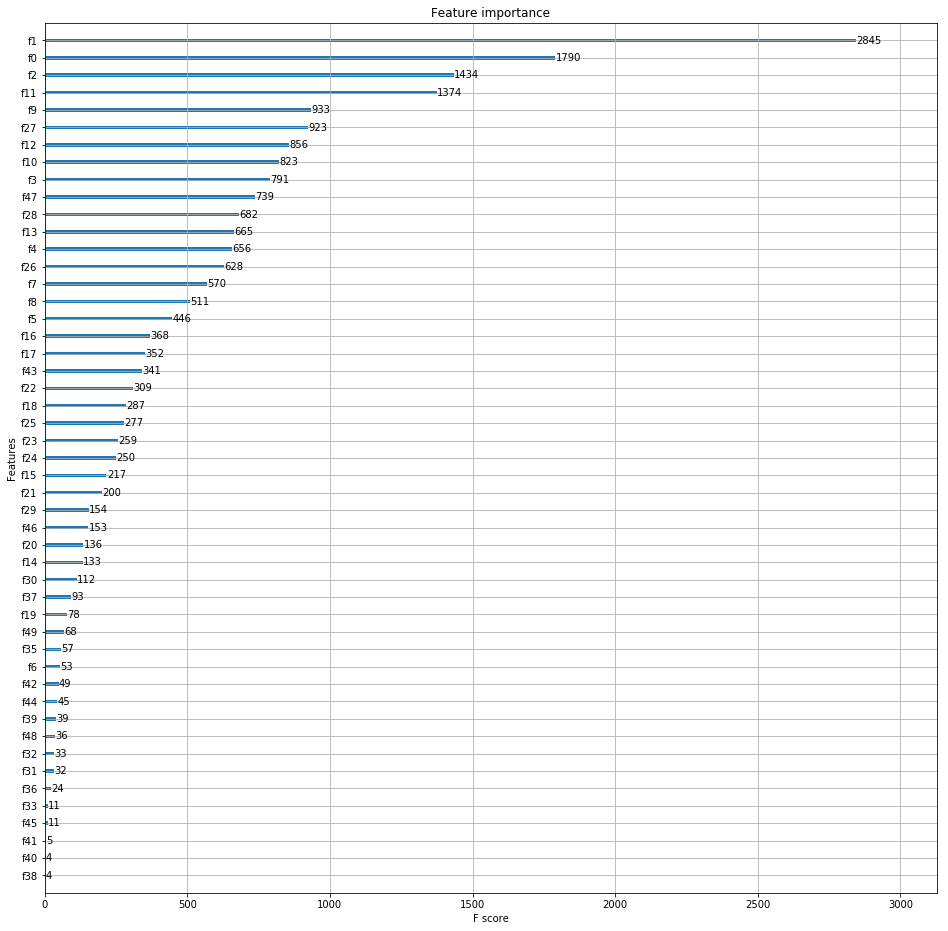

In [185]:
my_plot_importance(model_per_share,(16,16))
display_features(model_per_share,gain_loss_columns,False)
gain_loss_columns.columns[1]

## Display feature names

In [187]:
gain_loss_columns.columns[1]

'average_entry_price'

## Cut data for projecting stops

The idea is to train one XGBoost model on losses only, to predict losses for the wins.
And vice versa for the losses.

The logic behind this is we would like to know where Ryan would put his stop in the event of a win. Or guess at some sort of return in the event of a loss. If these prove fairly accurate, we can get an idea of where Ryan typically sets his stop loss, and how that might be improved by adjusting up or down depending on the situation.

In [188]:
num_columns = ['average_entry_price','quantity','firstEntSize','voljump30',
               'firstEntPrice','atr14','float','mktcap','spy_op','acv_crazy','vixpc_cl',
               'vix_op','ycv_per','acv_per','trade_volume','volume','prclose_chg',
                'spy200_lag','spy50_lag','spy10_lag','spy200','spy50',
                'spy10','vix_ovn','vvix_ret','vix_ret','spy_cl','atr14_lag','trade_duration'
              ]
cat_columns = ['is_long','entContra','earn_season',
               'entVenue','spyTrendUp','spyTrendDn','tradetype','mvolHi',
               'momo','posttrade','cb_day','cb_flag','halt_flag','volspike',
              'entLiqFlag','postvolspike','halt_reopen_elapse','avg_up','avg_dn',
                              'add_liq','entAddTake','held_overnight'
                             ]



target_column = 'percent_gain'
#'entContra',
fill_mean = True

# target_data = scale_data(useful_trades,cat_columns,num_columns,target_column,fill_mean=False)
target_data = useful_trades[num_columns + cat_columns]
target_data[cat_columns] = target_data[cat_columns].astype(str)
target_data[cat_columns] = target_data[cat_columns].apply(le.fit_transform)
target_data[num_columns].apply(pd.to_numeric)
target_data['percent_gain'] = useful_trades[target_column]

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Checking data values

In [198]:
print(target_data.columns)
print(max(target_data['percent_gain'].values))
print(max(trades['percent_gain'].values))
print(min(target_data['percent_gain'].values))
print(min(trades['percent_gain'].values))

Index(['average_entry_price', 'quantity', 'firstEntSize', 'voljump30',
       'firstEntPrice', 'atr14', 'float', 'mktcap', 'spy_op', 'acv_crazy',
       'vixpc_cl', 'vix_op', 'ycv_per', 'acv_per', 'trade_volume', 'volume',
       'prclose_chg', 'spy200_lag', 'spy50_lag', 'spy10_lag', 'spy200',
       'spy50', 'spy10', 'vix_ovn', 'vvix_ret', 'vix_ret', 'spy_cl',
       'atr14_lag', 'trade_duration', 'is_long', 'entContra', 'earn_season',
       'entVenue', 'spyTrendUp', 'spyTrendDn', 'tradetype', 'mvolHi', 'momo',
       'posttrade', 'cb_day', 'cb_flag', 'halt_flag', 'volspike', 'entLiqFlag',
       'postvolspike', 'halt_reopen_elapse', 'avg_up', 'avg_dn', 'add_liq',
       'entAddTake', 'held_overnight', 'percent_gain'],
      dtype='object')
0.3124930222968825
0.756268656716418
-0.3580870048289276
-0.7901041666666666


In [189]:
# target_data.isnull().sum()
for column in list(target_data.columns):
    print(column)
#     display_data_types(target_data[column].values)
    return_uniques(target_data[column].values)

average_entry_price
[3.28950850e-01 4.57300000e-01 5.70000000e-01 ... 1.11957139e+03
 1.14403616e+03 1.15478000e+03] [1 1 1 ... 1 1 1]
quantity
[1.00000000e+00 2.00000000e+00 2.00000000e+01 2.80000000e+01
 3.40000000e+01 5.00000000e+01 6.00000000e+01 1.00000000e+02
 1.25000000e+02 1.40000000e+02 1.41000000e+02 1.50000000e+02
 1.90000000e+02 2.00000000e+02 2.25000000e+02 2.27000000e+02
 2.50000000e+02 2.51000000e+02 2.66000000e+02 2.85000000e+02
 3.00000000e+02 3.01000000e+02 3.30000000e+02 3.40000000e+02
 3.47000000e+02 3.50000000e+02 3.75000000e+02 3.80000000e+02
 4.00000000e+02 4.23000000e+02 4.50000000e+02 4.79000000e+02
 5.00000000e+02 5.50000000e+02 5.57000000e+02 6.00000000e+02
 6.04000000e+02 6.50000000e+02 6.59000000e+02 6.61000000e+02
 6.70000000e+02 7.00000000e+02 7.03000000e+02 7.43000000e+02
 7.50000000e+02 7.75000000e+02 8.00000000e+02 8.29000000e+02
 8.40000000e+02 8.50000000e+02 8.71000000e+02 9.00000000e+02
 9.42000000e+02 9.50000000e+02 9.85000000e+02 1.00000000e+03
 1

## Train two models on wins and losses and generate projected stops

In [190]:
# X_train, X_valid, y_train, y_valid = return_data(useful_trades,cat_columns,num_columns,target_column,fill_mean)
# model = XGBoostTrain(X_train, X_valid, y_train, y_valid)

win_model = return_model(params)
loss_model = return_model(params)
# training on all the wins to project wins for losing trades
loss_perc_mask = target_data['percent_gain'] <= 0
win_perc_mask = target_data['percent_gain'] > 0
###
loss_predict = target_data[loss_perc_mask]
loss_x = loss_predict.drop(target_column,1).values
loss_y = loss_predict[target_column].values
win_predict = target_data[win_perc_mask]
win_x = win_predict.drop(target_column,1).values
win_y = win_predict[target_column].values

X_train, X_valid, y_train, y_valid = split_data(win_x,win_y)

# dtrain = xgb.DMatrix( X_train, label=y_train ) 
# dvalid = xgb.DMatrix( X_valid, label=y_valid )  
win_model = XGBoostTrain(X_train, X_valid, y_train, y_valid,win_model)
# win_model = do_train(X_train, X_valid, y_train, y_valid, initial_eta, min_eta, verbose=False)
wins_for_losses = win_model.predict(loss_x)
# wins_for_losses = win_model.predict(dvalid, ntree_limit=5, output_margin=True)

#training on all the losses to project losses for all the wins
X_train, X_valid, y_train, y_valid = split_data(loss_x,loss_y)
# dtrain = xgb.DMatrix( X_train, label=y_train ) 
# dvalid = xgb.DMatrix( X_valid, label=y_valid )  
loss_model = XGBoostTrain(X_train, X_valid, y_train, y_valid,loss_model)
# loss_model = do_train(X_train, X_valid, y_train, y_valid, initial_eta, min_eta, verbose=False)
losses_for_wins = loss_model.predict(win_x)
# losses_for_wins = loss_model.predict(dvalid, ntree_limit=5, output_margin=True)
# losses_for_wins = loss_model.predict(dvalid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_round=30, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
predictions [0.03315818 0.04388168 0.0048638  0.03234008 0.01406398]
mean and std of distance -0.0033907733017411496 0.02963751381416443
distance [-0.02051179 -0.03135317  0.01495627  0.02408849 -0.01126531]
targets [0.0126464  0.01252851 0.01982007 0.05642857 0.00279867]
Average distance: -0.0033907733017411496
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=

## Check how well the project stops came out. 

EG how many losses were still projected for the losses when we wanted wins and vice versa

In [206]:
print('max projected win',max(wins_for_losses))
print('min projected win',min(wins_for_losses))
print('max projected loss',max(losses_for_wins))
print('min projected loss',min(losses_for_wins))
print('Projected wins < 0',np.where(wins_for_losses < 0)[0].shape)
print('Projected losses > 0',np.where(losses_for_wins > 0)[0].shape)
print('length of wins_for_losses',len(wins_for_losses))
print('length of losses_for_wins',len(losses_for_wins))
print('min loss',min(loss_y))
print('max loss',max(loss_y))
print('min win',min(win_y))
print('max win',max(win_y))
print('shape of win projections',wins_for_losses.shape)
print('shape of loss projections',losses_for_wins.shape)
print(np.where(losses_for_wins > 0)[0].shape)
print(np.where(wins_for_losses <= 0)[0].shape)
print(wins_for_losses[:5])
print(losses_for_wins[:5])
assert wins_for_losses.shape[0] + losses_for_wins.shape[0] == useful_trades.shape[0]
print(max(trades['percent_gain']))
print(min(trades['percent_gain']))

max projected win 0.20566112
min projected win -0.0006297827
max projected loss -0.00088864565
min projected loss -0.16274613
Projected wins < 0 (3,)
Projected losses > 0 (0,)
length of wins_for_losses 1155
length of losses_for_wins 729
min loss -0.3580870048289276
max loss 0.0
min win 1.0117822037630274e-05
max win 0.3124930222968825
shape of win projections (1155,)
shape of loss projections (729,)
(0,)
(3,)
[0.00650021 0.00493151 0.03103235 0.00745305 0.00539538]
[-0.00265914 -0.00342298 -0.02643907 -0.01311004 -0.02760255]
0.756268656716418
-0.7901041666666666


## Incorporate the projected stops into the trading data.

In [210]:
a = np.zeros((useful_trades.shape[0],1))
print(a.shape)

(1884, 1)


In [211]:
# Slice the dataset, use the target columns, scale the data, predict the result
# Do that for both. Then concate the columns based on the masks. and add the result to "Projected Stops"
# Target_data is sliced and scaled. We mask target_data to generate predictions
target_losses = target_data[loss_perc_mask].drop(target_column,1).values
target_wins = target_data[win_perc_mask].drop(target_column,1).values
wins_ = win_model.predict(target_losses)
losses_ = loss_model.predict(target_wins)

useful_trades['projected_stop'] = np.zeros((useful_trades.shape[0],1))
useful_trades['projected_stop'][loss_perc_mask] = wins_
useful_trades['projected_stop'][win_perc_mask] = losses_
# Generate for all trades

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [212]:
useful_trades['projected_stop']

0       0.006500
1       0.004932
2      -0.002659
3      -0.003423
4      -0.026439
6      -0.013110
7       0.031032
8       0.007453
9       0.005395
10      0.004931
11      0.004154
12     -0.027603
17      0.006281
18      0.004886
19      0.010795
20      0.007046
21      0.005434
22      0.002883
23     -0.013705
24      0.002685
25      0.001043
27      0.004026
35      0.026081
37      0.005339
42     -0.006653
43      0.008244
44      0.006698
46     -0.005120
48      0.033328
49      0.039300
          ...   
3025    0.007181
3028    0.059534
3029    0.033491
3030    0.092036
3031    0.023307
3032    0.039897
3033    0.031707
3034    0.034582
3035   -0.029455
3036   -0.023179
3037   -0.020075
3038   -0.023449
3039    0.026932
3040    0.023701
3041   -0.027184
3042    0.022687
3043   -0.035007
3044    0.019851
3046   -0.010035
3047    0.050095
3048    0.057771
3050    0.064127
3051    0.051982
3052    0.054799
3053    0.057597
3054   -0.023049
3055    0.051161
3057   -0.0092

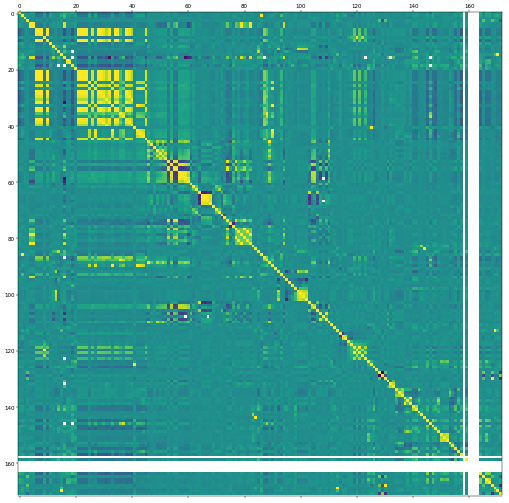

In [214]:
path = '/Users/morgan/Documents/Ryan_correlations/Projected_stops'
name = 'Useful_projected'
save_show_correlations(useful_trades,path,name)

In [215]:
projected_path = '/Users/morgan/Documents/Ryan_correlations/Projected_stops/Useful_projected.csv'
display_correlation_values(projected_path)

Index(['Unnamed: 0', 'idsym', 'quantity', 'is_long', 'realized',
       'open_fill_id', 'close_fill_id', 'average_entry_price',
       'average_exit_price', 'firstEntPrice',
       ...
       'is_lev', 'use?', 'finviz_vol', 'per_share_return', 'atr14_percent',
       'atr14_lag_percent', 'percent_gain', 'trade_duration', 'held_overnight',
       'projected_stop'],
      dtype='object', length=173) (172, 173)
positive_cols 
 ['spy_ret_lag', 'earn_season', 'avg_up', 'yest_gte_adv', 'open_chg', 'tradetype', 'holdmins', 'trade_duration', 'ovntrade', 'held_overnight', 'vol_amp', 'volume', 'first_ex_50p', 'yestvoljump', 'volspike', 'acv_crazy', 'ay_ratio', 'realized', 'per_share_return', 'wintrade']
negative_cols 
 ['projected_stop', 'losstrade', 'ovn_chg', 'prclose_chg', 'lastExSize', 'halt_reopen_elapse', 'voljump', 'avg_dn', 'lo_price', 'avg_type', 'finviz_vol', 'cb_day', 'atr14_lag_percent', 'spy10_lag', 'spy10', 'cb_flag', 'voljump30_dn', 'voldayjump', 'ipo_trade_day', 'both_dn']
Positi

In [ ]:
# # Trade columns split into numerical and categorical
# trades_categorical = ['idsym','symbol','is_long','entVenue',
#                       'entLiqFlag','entContra','entAddTake','exVenue',
#                      'exLiqFlag','exContra','exAddTake','earn_season',
#                       'earntrade','posttrade','ovntrade','cb_day','cb_flag',
#                       'halt_flag','tradetype','typelong','moc','prodtype','fang',
#                      'add_liq','open_time','second_time','close_time','premkt','postmkt',
#                      'prePost','timeSum','timeNum','hiVix','vixBack','spyUp','spyTrendUp',
#                       'spyTrendDn','spyTrendCode','spyTrend','mvolHi','rebal','witch','newHi',
#                      'newLo','newHiLo','avg_up','avg_dn','avg_type','avg_typelong','first_ex_50p',
#                       'big_ent_size','big_ent_mv','bigmove','momo','wintrade','losstrade','trend_up',
#                       'trend_dn','trend_type','trend_long','ycv_dn','acv_dn','both_dn','acv_gte_ycv',
#                       'yest_gte_adv','ycv_crazy','acv_crazy','vol_reverse','lo_mc','float_huge',
#                       'lo_price','lo_vol','voljump30_dn','voldown','volspike','postvolspike','lo_atr',
#                       'is_etf','vol_amp','ultra','lev','is_lev','use?','held_overnight'
#                      ]
# trades_numerical = ['quantity','realized','average_entry_price',
#                     'average_exit_price','firstEntPrice','firstEntSize',
#                     'lastExPrice','lastExSize','high','low','open','close',
#                    'volume','atr14','vol5','sma10','sma50','hi52w','lo52w',
#                    'sma200','vol30','hi30d','lo30d','mktcap','float','pr_close',
#                     'hi52w_lag','lo52w_lag','ovn_chg','vol30_lag','vol5_lag','vol_lag',
#                    'atr14_lag','mvol','mvol_chg','mvol_chg_lag','mvol_ptile50',
#                     'mvol_ptile50_lag','mvol_ptile200','mvol_ptile200_lag','spy_op',
#                    'vix_op','spy_cl','spy_adj_cl','vix_cl','vxv_cl','vxst_cl','vvix_cl',
#                    'skew_cl','idxpc_cl','vixpc_cl','spy_adj_ret','vix_ret',
#                    'vxv_ret','vxst_ret','vvix_ret','skew_ret','idxpc_ret',
#                    'vixpc_ret','spy_ovn','vix_ovn','spy_adj_cl_lag','spy_ret_lag',
#                     'vix_ret_lag','spy10','spy50','spy200','spy10_lag','spy50_lag',
#                    'spy200_lag','acv_per','ycv_per','trade_volume','mcB','mvolB','vol30_lagM',
#                    'mv','spy_ret_oc','holdmins','first_ex_per','open_mv','ent_size_z','ent_mv_z',
#                    'open_chg','prclose_chg','trade_return','ay_ratio','acv_atr','ycv_atr',
#                     'yestvoljump','voldayjump','voljump','voljump30','per_share_return',
#                     'atr14_percent','atr14_lag_percent','trade_duration'
#                    ]
# target_column = 'percent_gain'
# trades_cat = trades[trades_categorical]
# trades_num = trades[trades_numerical]
# # trades_tar = trades[target_column]

In [ ]:
# for index,value in enumerate(trades['trend_long'].values):
#     print(type(value))
#     if type(value) == float:
#         pass
# #         print(type(value))
# #         print( value,index)
        

In [ ]:
# # trades_cat = trades_cat.apply(le.fit_transform)
# # scaler.fit(trades_num)
# # temp_num = scaler.transform(trades_num)
# # trades_num = pd.DataFrame(temp_num,columns=trades_numerical)
# trades.head(5)

In [ ]:
# print(trades_num.shape)
# print(trades_cat.shape)
# trades_cat = trades_cat.apply(le.fit_transform)
# scaler.fit(trades_num)
# temp_num = scaler.transform(trades_num)
# trades_num = pd.DataFrame(temp_num,columns=trades_numerical)
# # trades_num.fillna(trades_num.mean(), inplace=True)
# combined_trades = pd.concat([trades_cat,trades_num],axis=1)
# #get only the columns that matter without too much data leakage
# target_data = combined_trades[cat_columns + num_columns]
# target_data[target_column] = trades[target_column]

In [ ]:
# ## Train two XGBoost algos on losses and wins
# loss_perc_mask = target_data['percent_gain'] <= 0
# win_perc_mask = target_data['percent_gain'] > 0

# # Make sure all the rows are present
# assert loss_perc_mask.shape[0] == trades.shape[0]
# assert win_perc_mask.shape[0] == trades.shape[0]
# print(loss_perc_mask.shape)
# print(win_perc_mask.shape)

# loss_predict = target_data[loss_perc_mask]
# win_predict = target_data[win_perc_mask]
# # Get X and Y
# loss_x = loss_predict.drop(target_column,1).values
# loss_y = loss_predict[target_column].values
# win_x = win_predict.drop(target_column,1).values
# win_y = win_predict[target_column].values


# print(win_x.shape,win_y.shape)
# print(loss_x.shape,loss_y.shape)
# # win_model = XGBoostTrainOnly(win_x,win_y)
# # loss_model = XGBoostTrainOnly(loss_x,loss_y)

# # print(wins_for_losses.shape)
# # print(losses_for_wins.shape)

# X_train, X_valid, y_train, y_valid = split_data(win_x,win_y)
# win_model = XGBoostTrain(X_train, X_valid, y_train, y_valid)
# X_train, X_valid, y_train, y_valid = split_data(loss_x,loss_y)
# loss_model = XGBoostTrain(X_train, X_valid, y_train, y_valid)
# # win_model = XGBoostTrain(X_train, X_valid, y_train, y_valid)

# # training on all the losses to project losses for all the wins
# # X_train, X_valid, y_train, y_valid = split_data(loss_x,loss_y)
# # loss_model = XGBoostTrain(X_train, X_valid, y_train, y_valid)

# wins_for_losses = win_model.predict(loss_x)
# losses_for_wins = loss_model.predict(win_x)

In [ ]:
# my_plot_importance(win_model,(16,16))

In [ ]:
# print(target_data.columns[0])

In [ ]:
# print(np.where(loss_predict[target_column] <= 0)[0].shape)
# print(np.where(win_predict[target_column] > 0)[0].shape)
# losses = loss_model.predict(loss_x)
# print(max(losses))
# print(np.where(losses > 0)[0].shape)

In [ ]:
# #Need to reuse the scaler and categories

# projected_stops = []
# win_index = 0
# loss_index = 0
# for index, row in trades.iterrows():
#     #Check if trade was win or not
#     percent_gain = row[-3]
#     if percent_gain <= 0:
#         # add win to the loss
#         projected_stops.append(wins_for_losses[loss_index])
#         loss_index += 1
#     else:
#         # add loss to the win
#         if win_index == 1091:
#             print(index)
#         projected_stops.append(losses_for_wins[win_index])
#         win_index += 1
# #     projected_stops.append(projected_stop)
    
# # create new feature for trades
# print(len(projected_stops))
# # trades['projected_stop'] = projected_stops

# Last but not least

+ Checking quantity vs stock price 
+ Dollar amount vs stock price

In order to see if investment is being scaled across stock prices and is agnostic vs stock price e.g. trading based on dollar amount, or if there is some relationship there. Stock prices that are high are generally frequently traded, well regarded and have high liquidity. Whereas stock prices that are low can be speculative (bio stocks that are dependant on a drug getting approval for example.) although that is not always the case since stocks can be split.


[3.28950850e-01 3.56936290e-01 4.09906660e-01 ... 1.86422467e+03
 1.87186862e+03 1.87263333e+03] [1 1 1 ... 1 1 1]


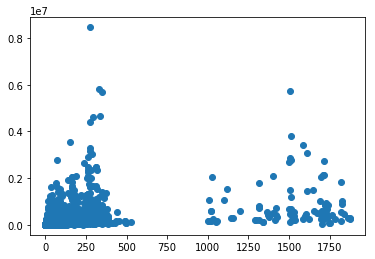

In [193]:
# Check if quantity scales over stock price
stock_prices = trades['average_entry_price'].values
quantities = trades["quantity"].values

dollar_amounts = [quant*stock_prices[index] for index,quant in enumerate(quantities)]

uniques,counts = return_uniques(stock_prices)
# plt.plot(stock_prices)
# plt.plot(dollar_amounts)
plt.scatter(stock_prices,dollar_amounts)

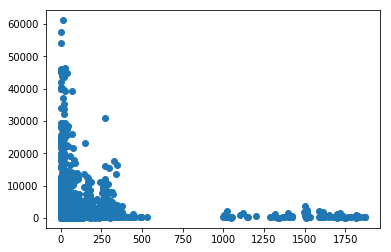

In [194]:
plt.scatter(stock_prices,quantities)

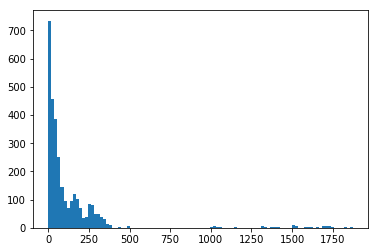

In [195]:
plt.hist(stock_prices,bins=100)
plt.show()

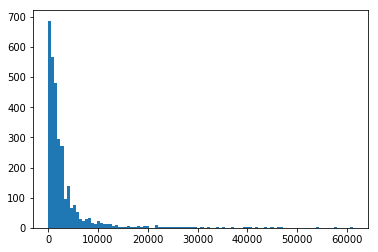

In [196]:
plt.hist(quantities,bins=100)
plt.show()

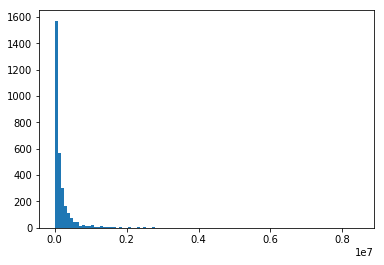

In [197]:
plt.hist(dollar_amounts,bins=100)
plt.show()

# Conclusion

### Sectors and Industries to avoid

+ Healthcare
+ Utilities

### Metrics to exploit and avoid

Volume is well correlated with doing well. This makes sense in terms of ease of enter/exiting the stock as well as being present when the stock(s) are moving a lot.

Earnings would be well correlated with volume as those are times when the stock is potentially incorporating new information and then readjusting to new prices.

Volatility. Low volatility means less noise in the stock, this is useful when avoiding getting your stop triggered, as well as meaning you can put the stop closer to your entry point without worrying about noise triggering it. When the stop does get triggered, we can be more confidant that its a reliable signal of new direction and perhaps we have missed something important. Alternatively high volatility could mean high interest in the stock. Or algorithmic trading?

ATR. Indicative of stock movement. Which is in line with the previous statements

Duration. The longer a stock has been held, the higher likelyhood we have made money, as the stop hasn't been triggered. Exception being when we are short. Probably due to the fact that you must borrow and pay for shares on a daily basis.

Vix. Generally negatively correlated. Vix being an indication of fear. low vix correlated with upward trend in stocks, whereas high vix can mean sharp movements and downturns.

Volspike and postvolspike. These are nicely deliniated between positive and negative.

Positive metrics:

atr (average true range) percents are all positively correlated.
+ Duration
   + **Shorts** is the exception where duration is negatively correlated.
+ Volume
+ Vol_spike - *1 if day volume >2x prior day volume; 0 otherwise (some look-ahead bias here given using full day’s trading volume)*
+ atr14_percent
+ atr14_lag_percent
+ avg_up
+ finviz_vol *is strongly correlated with minimizing losses and increasing gains in Win/Loss*

Negative metrics:

+ post_vol_spike - *1 if day volume < prior day’s volume & prior day’s volume > 1.5x trailing 30d avg volume; 0 otherwise*
+ ipo_trade_day
+ quantity
+ momo
+ avg_dn
+ Open_mv
+ lo52w
+ lo52w_lag
Both are negatively associated in Wins/Losses. As in they reduce the size of wins and increase the size of losses.

Vix attributes:
I don't know what all of these are, but there are some clear correlations. In general the hypothesis of return being inversely correlated with vix (volatility) seems to be true, aside from [vixpc_ret,vixpc_cl,vxv_ret]

Positive:
+ vixpc_ret
+ vixpc_cl
+ vxv_ret

Negative
+ vxv_cl - Vxv close
+ vix_cl - Vix close
+ vix_op - Spot vix open
+ vvix_cl
+ vxst_cl
+ vix_ovn
+ vix_ret
+ vvix_ret

Alternating:
+ vxv_ret
+ vix_ovn
+ vix_ret_lag

